<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

The dataset is a subset of the **MovieLens** dataset, a benchmark dataset provided by GroupLens for building and evaluating recommender systems.

It consists of two main components:

1. **`movies` DataFrame**
   This contains metadata about each movie. Each row includes a unique `movieId`, the `title` (e.g., *Toy Story (1995)*), and a pipe-separated list of `genres` (e.g., *Adventure|Animation|Children|Comedy|Fantasy*).

2. **`ratings` DataFrame**
   This captures user interactions. Each entry includes a `userId`, a `movieId` (referring to a movie from the `movies` DataFrame), a numeric `rating` (from 0.5 to 5.0), and a `timestamp` representing when the rating was recorded.

Together, these datasets support both **collaborative filtering** (via user ratings) and **content-based filtering** (via genre metadata).


# Import Required Libraries

In [8]:
# This section imports all necessary libraries for data processing, similarity computation, evaluation, and visualization.
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Exploratory Data Analysis and Implications for Recommender System Design


Unique Users        : 200,948
Unique Movies       : 84,432
Actual Ratings      : 32,000,204
Density of Ratings  : 0.1886%


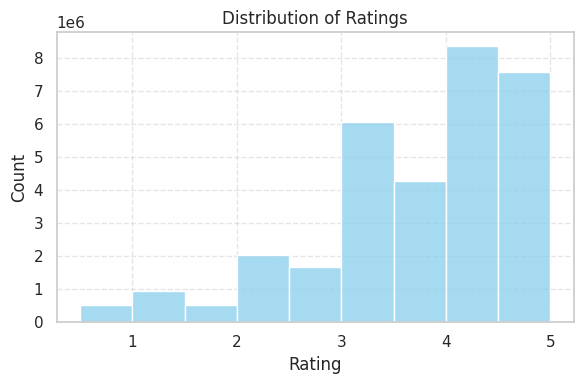

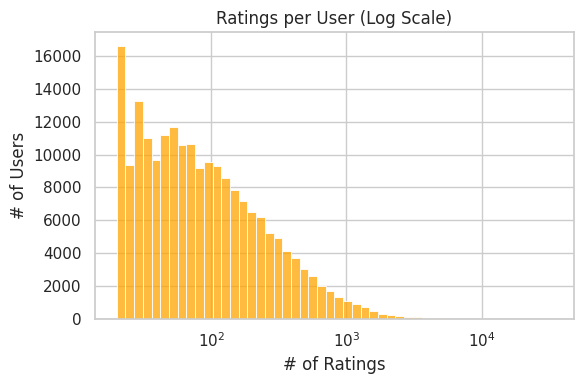

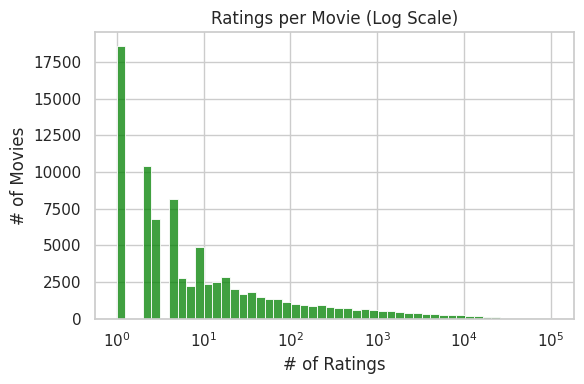

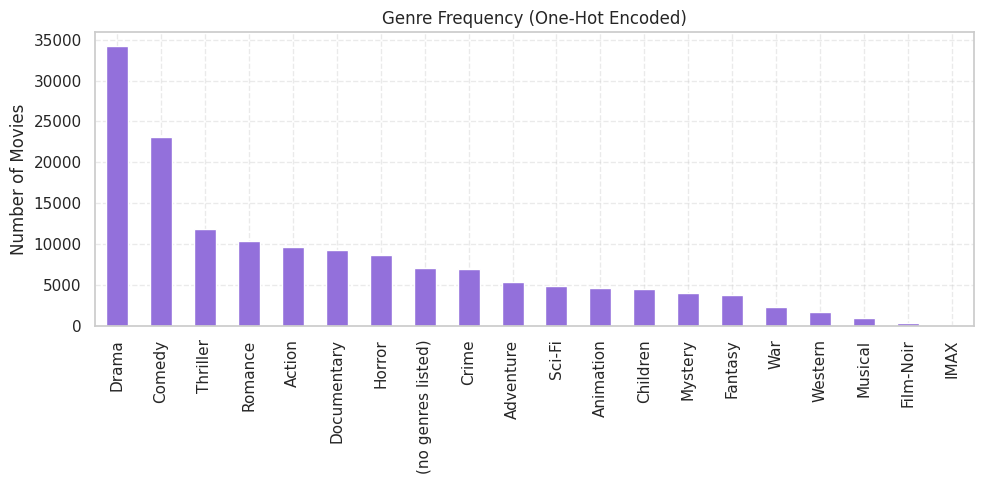

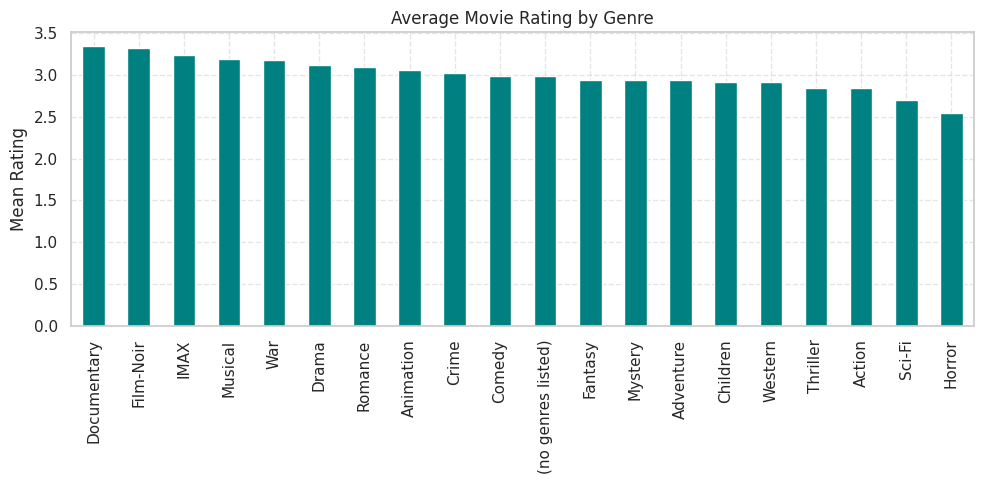

In [9]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv("movies.csv")

# --- Step 2: Explode Genres ---
movies['genres'] = movies['genres'].fillna('(no genres listed)').str.split('|')

# Step 1: Explode the genres into individual rows
movies_with_genres = movies.explode('genres').reset_index(drop=True)

# Step 2: One-hot encode the exploded genres
genre_dummies = pd.get_dummies(movies_with_genres['genres'])

# Step 3: Combine with movieId and group to get multi-hot encoding
movies_with_genres = movies_with_genres[['movieId']].join(genre_dummies)
movies_with_genres = movies_with_genres.groupby('movieId').max().reset_index()

# movies_with_genres = pd.read_csv('/content/movies_with_genres_onehot.csv')

# --- Step 2: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 3: Ratings Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Step 4: Ratings per User ---
user_counts = ratings['userId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(user_counts, bins=50, log_scale=True, color='orange')
plt.title("Ratings per User (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Users")
plt.tight_layout()
plt.show()

# --- Step 5: Ratings per Movie ---
movie_counts = ratings['movieId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(movie_counts, bins=50, log_scale=True, color='green')
plt.title("Ratings per Movie (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Movies")
plt.tight_layout()
plt.show()

# --- Step 6: Genre Frequency from One-Hot ---
genre_cols = [col for col in movies_with_genres.columns if col not in ['movieId', 'title']]
genre_freq = movies_with_genres[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
genre_freq.plot(kind='bar', color='mediumpurple')
plt.title("Genre Frequency (One-Hot Encoded)")
plt.ylabel("Number of Movies")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Step 7: Ratings Diversity per Genre ---
# Strategy: Merge genre flags with mean rating per movie
movie_means = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_stats = pd.merge(movie_means, movies_with_genres, on='movieId', how='inner')

# Compute average rating per genre
genre_rating_avg = {}
for genre in genre_cols:
    genre_rating_avg[genre] = movie_stats[movie_stats[genre] == 1]['rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
pd.Series(genre_rating_avg).sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Average Movie Rating by Genre")
plt.ylabel("Mean Rating")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Dataset Overview**

The MovieLens dataset contains:

* 32,000,204 ratings
* 200,948 unique users
* 84,432 unique movies
* User-Movie Matrix Density: 0.1886%

This confirms the dataset is extremely sparse—fewer than 2 out of every 1,000 user-movie pairs have an actual rating. Sparsity is a key challenge for recommender systems.

**Rating Distribution**

The majority of ratings cluster between 3.0 and 5.0, especially at 4.0, suggesting user positivity bias. Very few 0.5–2.0 ratings were observed.

**2. Genre & Rating Relationships**

Stacked bar plots and heatmaps reveal how ratings are distributed across genres. Drama, Comedy, and Action dominate across all rating levels, especially in the 3.0–4.5 range. These patterns help identify genres with enough data to support collaborative filtering.

**Rating Coverage per Movie**

A long-tail distribution is observed: most movies receive few ratings, while a small group are extremely well-rated (e.g., *Shawshank Redemption*, *Forrest Gump*).

**Rating Coverage per User**

Most users have rated fewer than 100 movies. Only a few users contribute large numbers of ratings, showing heavy-tailed user behavior.

**Top Movies**

Popular titles have over 90,000 ratings, offering a strong base for collaborative filtering.

### Recommender System Suitability Analysis

#### Content-Based Filtering

* Well-suited for this dataset due to extreme sparsity
* Genre metadata is available for every movie
* Limitation: Genre tags may not capture nuanced content (e.g., plot, style, mood)
* Best suited for cold-start scenarios involving new users or items

#### User-User Collaborative Filtering

* Struggles with data sparsity
* Low overlap between users makes similarity scores unreliable
* Performs better for active users with more than 100 ratings
* Suitable for active user communities or filtering power users

#### Item-Item Collaborative Filtering

* More stable than user-based filtering because items remain in the system
* Reusable similarity matrices improve efficiency
* Suffers when co-rating between items is low (as in long-tail items)
* Best for frequently rated or popular items

#### Conclusion and Recommendations

Given the high sparsity, skewed rating distribution, and long-tail item activity:

* A hybrid recommendation system is recommended
* Content-based filtering is essential for handling cold-start problems
* Item-based collaborative filtering should be prioritized over user-based approaches when rating density allows
* Popularity-based or genre-average fallback models should be implemented for sparse edge cases
* Consider extending metadata (e.g., tags, plot descriptions) or adopting matrix factorization models to uncover deeper patterns in sparse user behavior


## Sample and Split the Data

In [2]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Load Datasets ---
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Step 1: Filter Active Users and Bin Ratings ---
user_stats = merged_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(10000)

# Filter merged_df to active users only
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Step 2: Genre Weights Based on Rarity ---
all_genres_combined = '|'.join(merged_df['genres'].dropna().values)
genre_counts = Counter(all_genres_combined.split('|'))
genre_weights_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_weights_df['inv_weight'] = genre_weights_df['count'].max() / genre_weights_df['count']
genre_weights_df['norm_weight'] = genre_weights_df['inv_weight'] / genre_weights_df['inv_weight'].sum()
genre_weight_dict = genre_weights_df['norm_weight'].to_dict()

def get_genre_weight(genres, weight_dict):
    for genre in genres.split('|'):
        if genre in weight_dict:
            return weight_dict[genre]
    return 0

# --- Step 3: Sample Movies Based on Genre Weights ---
movie_metadata = merged_df[['movieId', 'title', 'genres']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genres'].apply(lambda x: get_genre_weight(x, genre_weight_dict))
movie_metadata.dropna(subset=['weight'], inplace=True)

sampled_movies = movie_metadata.sample(n=5000, weights='weight', random_state=42)
sampled_movie_ids = sampled_movies['movieId'].unique()

# --- Step 4: Create Stratified Dataset ---
stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

# Keep users with at least 10 ratings in this subset
rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
eligible_users = rating_density[rating_density['num_ratings'] >= 10]['userId']
stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

# --- Step 5: Train-Test Split ---
train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

print(train_ratings.shape, test_ratings.shape)

(106266, 6) (26567, 6)


## Filtering Approach for Limited Compute Resources

The data filtering strategy used in this recommender system is directly informed by insights from the exploratory data analysis (EDA):

**1. Filtering to Active Users (≥100 ratings):**
The EDA showed that the majority of users have rated fewer than 100 movies, resulting in sparse and unreliable user profiles. By focusing on the top 10,000 users with the most ratings, the approach ensures sufficient overlap for meaningful similarity calculations, especially important for collaborative filtering methods.

**2. Genre-Based Movie Sampling with Weighted Probabilities:**
Since genres like Drama and Comedy dominate the dataset, uniform sampling would skew the representation toward popular genres. Weighting genres inversely by frequency ensures a more balanced movie selection, introducing genre diversity and improving the model’s generalizability.

**3. Minimum Ratings Per User in Sampled Set:**
To prevent sparsity within each sampled subset, users are retained only if they rate a minimum number of sampled movies (e.g., 5, 10, 15, 20). This ensures that the user-item matrix is sufficiently dense for similarity-based predictions.

**4. Bias Correction in Predictions:**
The rating distribution is positively skewed, with most ratings between 3.0 and 5.0. Incorporating global, user, and item bias corrections helps neutralize systematic rating tendencies, improving prediction accuracy.

**5. Grid-Based Optimization:**
Given the sparse nature of the full matrix (\~0.19% density), the grid search across sample sizes and minimum rating thresholds enables identification of the best-performing configurations while maintaining computational efficiency.

Overall, the filtering strategy is a necessary and effective response to the sparsity, skew, and imbalance revealed during EDA. It improves model reliability and allows for scalable experimentation.


# Collaborative Filtering

## Common Methodology (Excludes Preprocessing)

**Rating Matrix Construction**

* Construct a user-item matrix from the training data, with users as rows, movies as columns, and ratings as values.

**Global and Bias Statistics**

* Compute the global mean rating across all ratings.
* Calculate per-user and per-item average ratings to estimate user bias (tendency to rate higher or lower) and item bias (general popularity or unpopularity).

**Prediction Logic**

* For each (user, item) pair in the test set:

  * If the user or item is missing in the training data, fall back to the global mean or a bias-corrected estimate.
  * Identify items rated by the user that are similar to the target item.
  * Normalize the similarity scores to use them as weights.
  * Compute a weighted sum of rating residuals (difference between user rating and item average).
  * Add this sum to the global mean and apply bias correction from user and item averages.
  * Clip the result within the valid rating scale (e.g., 0.5 to 5.0).

**Parallelized Predictions**

* Apply parallel processing to speed up predictions across the test set using tools like `joblib.Parallel`.

**Evaluation Metrics**

* Assess prediction performance using:

  * RMSE (Root Mean Squared Error)
  * MAE (Mean Absolute Error)
  * R² (Coefficient of Determination)

**Visualization**

* Sample a subset of the results and generate the following plots:

  * Box plot comparing actual vs. predicted rating distributions.
  * KDE plot showing the density of actual and predicted ratings.
  * Residual plot to assess prediction errors.
  * Scatter plot of predicted vs. actual ratings for visual alignment.



## **Item-Item Collaborative Filtering**

### ***1. Item-Item Collaborative Filtering with Cosine Similarity***

This script implements a traditional item-based collaborative filtering model using cosine similarity.
The key objective is to predict a user's rating for a given item based on the similarity between that
item and others the user has already rated.

Workflow Summary:
-----------------
1. **Data Preparation**:
   - The dataset is split into training and test sets.
   - A user-item rating matrix is created from the training data.

2. **Similarity Computation**:
   - Ratings are mean-centered by user.
   - Cosine similarity is computed between items (columns) in the centered matrix.

3. **Rating Prediction**:
   - For each (user, item) pair in the test set, the predicted rating is computed as a weighted sum
     of deviations from item means, using the similarity weights of items the user has rated.
   - User and item biases are optionally included.

4. **Evaluation Metrics**:
   - Root Mean Squared Error (RMSE)
   - Mean Absolute Error (MAE)
   - R² Score (Coefficient of Determination)

5. **Visualization**:
   - Distribution comparison (box plot, KDE)
   - Residual analysis
   - Scatter plot of actual vs predicted ratings

Note:
-----
- This is a memory-based CF approach using no external content features.
- Ratings are clipped to the valid range [0.5, 5.0].

Item-Item CF with Cosine Similarity:
RMSE = 0.9102, MAE = 0.6868, R² = 0.2624


/tmp/ipython-input-36-1936921308.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')
/tmp/ipython-input-36-1936921308.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data_cosine, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
/tmp/ipython-input-36-1936921308.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])


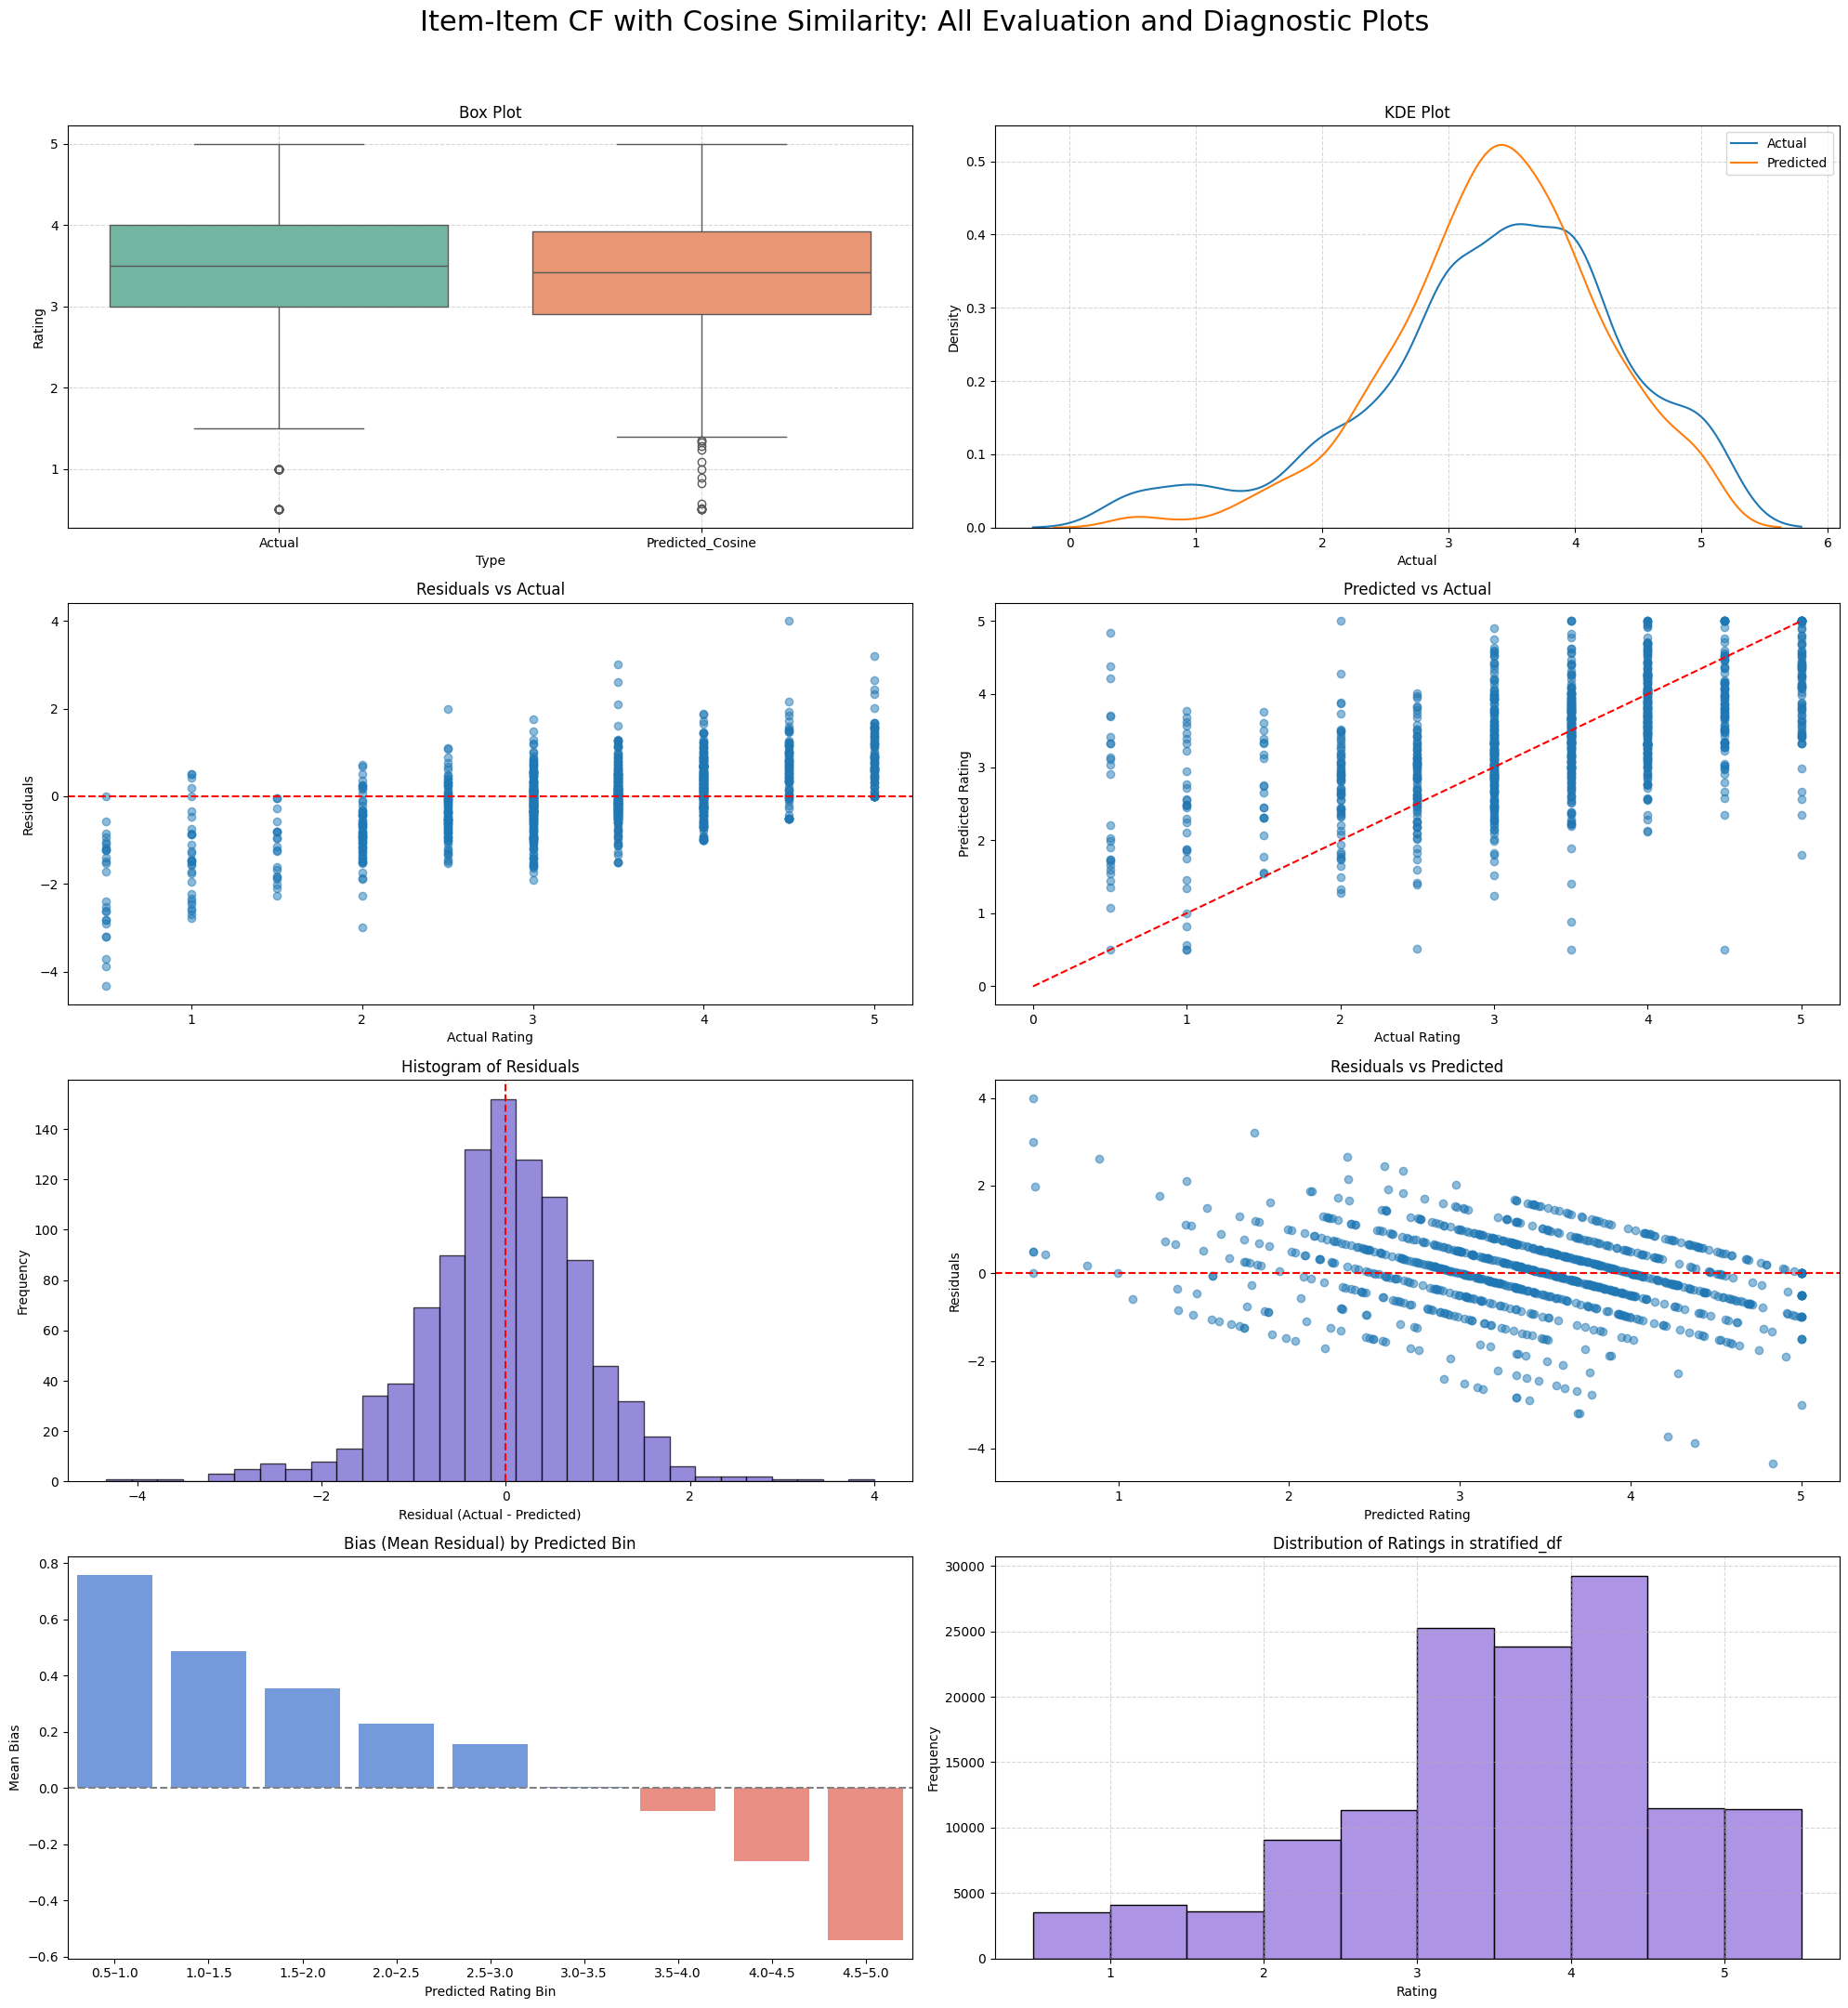

In [36]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: User-Item Matrix & Common Stats ---
user_item_matrix_common = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean_common = train_ratings['rating'].mean()
item_means_common = train_ratings.groupby('movieId')['rating'].mean()
user_means_common = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Save to Parquet ---
user_item_matrix_common.to_parquet("user_item_matrix_common.parquet")
item_means_common.to_frame("item_mean").to_parquet("item_means_common.parquet")
user_means_common.to_frame("user_mean").to_parquet("user_means_common.parquet")

# --- Step 4: Compute and Save Similarity Matrix ---
user_item_centered_common = user_item_matrix_common.sub(user_item_matrix_common.mean(axis=1), axis=0)
item_item_sim_matrix_cosine = pd.DataFrame(
    cosine_similarity(user_item_centered_common.T.fillna(0)),
    index=user_item_centered_common.columns,
    columns=user_item_centered_common.columns
)
item_item_sim_matrix_cosine.to_parquet("item_item_sim_matrix_cosine.parquet")

# --- Step 5: Load Matrices ---
user_item_matrix_common = pd.read_parquet("user_item_matrix_common.parquet")
item_means_common = pd.read_parquet("item_means_common.parquet")['item_mean']
user_means_common = pd.read_parquet("user_means_common.parquet")['user_mean']
item_item_sim_matrix_cosine = pd.read_parquet("item_item_sim_matrix_cosine.parquet")

# --- Step 6: Prediction Function ---
def predict_rating_item_item_cosine(uid, mid):
    if uid not in user_item_matrix_common.index or mid not in item_item_sim_matrix_cosine.index:
        return global_mean_common

    sims = item_item_sim_matrix_cosine[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_common.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Parallel Predictions Without Progress Bar ---
def parallel_predict_cosine(row):
    uid, mid, actual = row.userId, row.movieId, row.rating
    pred = predict_rating_item_item_cosine(uid, mid)
    return [uid, mid, actual, pred]

results_cosine = Parallel(n_jobs=-1, backend="loky")(
    delayed(parallel_predict_cosine)(row) for row in test_ratings.itertuples(index=False)
)

viz_df_cosine = pd.DataFrame(results_cosine, columns=['userId', 'movieId', 'Actual', 'Predicted_Cosine'])

# --- Step 8: Evaluation ---
rmse_cosine = np.sqrt(mean_squared_error(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine']))
mae_cosine = mean_absolute_error(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine'])
r2_cosine = r2_score(viz_df_cosine['Actual'], viz_df_cosine['Predicted_Cosine'])

print(f"Item-Item CF with Cosine Similarity:\nRMSE = {rmse_cosine:.4f}, MAE = {mae_cosine:.4f}, R² = {r2_cosine:.4f}")

# --- Step 9: Plotting All Diagnostics in One Faceted Grid ---
viz_sample_cosine = viz_df_cosine.sample(n=min(len(viz_df_cosine), 1000), random_state=42)
residuals_cosine = viz_sample_cosine['Actual'] - viz_sample_cosine['Predicted_Cosine']
box_data_cosine = viz_sample_cosine[['Actual', 'Predicted_Cosine']].melt(var_name='Type', value_name='Rating')

# Bias Summary
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_cosine['pred_bin'] = pd.cut(viz_df_cosine['Predicted_Cosine'], bins=bins, labels=bin_labels, include_lowest=True, right=False)
viz_df_cosine['Residual_Cosine'] = viz_df_cosine['Actual'] - viz_df_cosine['Predicted_Cosine']
bias_summary = (
    viz_df_cosine
    .groupby('pred_bin')
    .agg(Mean_Residual=('Residual_Cosine', 'mean'))
    .reset_index()
)

# Create Faceted Plot Grid
fig, axs = plt.subplots(4, 2, figsize=(20, 22))
fig.suptitle("Item-Item CF with Cosine Similarity: All Evaluation and Diagnostic Plots", fontsize=22)

# --- Plot 1: Box Plot ---
sns.boxplot(data=box_data_cosine, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: KDE Plot ---
sns.kdeplot(viz_sample_cosine['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_cosine['Predicted_Cosine'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Plot 3: Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_cosine['Actual'], residuals_cosine, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Plot 4: Predicted vs Actual ---
axs[1, 1].scatter(viz_sample_cosine['Actual'], viz_sample_cosine['Predicted_Cosine'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Plot 5: Histogram of Residuals ---
axs[2, 0].hist(residuals_cosine, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Plot 6: Residuals vs Predicted ---
axs[2, 1].scatter(viz_sample_cosine['Predicted_Cosine'], residuals_cosine, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# --- Plot 7: Bias by Predicted Bin ---
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='pred_bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Bias")

# --- Plot 8: Distribution of Ratings ---
sns.histplot(stratified_df['rating'], bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


***Evaluation of Item-Item Collaborative Filtering with Cosine Similarity and Bias Correction***

The model yields RMSE = 0.9102, MAE = 0.6868, and R² = 0.2624, indicating moderate accuracy with limited variance explained. It handles average ratings reasonably well but struggles with extremes.

The residual and predicted vs. actual plots show consistent overestimation of low ratings and underestimation of high ratings. This pattern is reinforced by the KDE and boxplot, where predicted ratings cluster tightly around the mean, lacking the spread seen in actual ratings. The model regresses toward the mean.

EDA justifies this behavior. The rating distribution is right-skewed, with most values between 3 and 5, inflating item and global means. This leads the model to overpredict for unpopular items and underpredict for highly rated ones. Log-scale histograms show most users and items have few ratings, limiting co-rated overlaps and weakening item similarity estimates. This sparsity causes overly conservative predictions and explains the model’s narrow prediction range and modest R².

Overall, the model’s behavior is aligned with data structure. While functional for mid-range ratings, its effectiveness is constrained by sparsity and reliance on mean-based bias correction. Improvements like shrinkage or hybrid models could address these limitations.


### ***2. IUF-Based Item-Item Collaborative Filtering***

IUF-Based Item-Item Collaborative Filtering

This script implements an item-based collaborative filtering model enhanced with
Inverse User Frequency (IUF) weighting to reduce the dominance of universally-rated items.

Main steps:
1. Data Preparation
   - Fill missing genre data
   - Train-test split
   - Construct a user-item rating matrix grouped by userId and movieId

2. IUF Weighting
   - Apply IUF transformation to downweight popular items
   - Save both raw and IUF-weighted matrices

3. Similarity Matrix Computation
   - Compute cosine similarity between items using the IUF-weighted matrix

4. Rating Prediction with Bias Correction
   - Predict ratings using similarity-weighted deviation from item means
   - Adjust predictions using user and item bias
   - Clip predictions to valid rating range [0.5, 5.0]

5. Evaluation
   - Compute RMSE, MAE, and R² score on the test set

6. Visualization
   - Box plot of actual vs predicted ratings
   - KDE plot of rating distributions
   - Residuals vs actual ratings
   - Scatter plot of predicted vs actual ratings

This model is a memory-based collaborative filtering approach, enhanced with IUF to mitigate popularity bias, using only explicit rating data (no content features).



In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Step 2: Pivot User-Item Matrix ---
train_ratings_grouped = train_ratings.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_common = train_ratings_grouped.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Apply IUF and Save Matrices ---
def apply_iuf_weighting(matrix):
    user_counts = (~matrix.isna()).sum(axis=0)
    iuf = np.log(matrix.shape[0] / (user_counts + 1e-9))
    return matrix.multiply(iuf, axis=1)

user_item_matrix_iuf = apply_iuf_weighting(user_item_matrix_common)

user_item_matrix_common.to_parquet("user_item_matrix_common.parquet")
user_item_matrix_iuf.to_parquet("user_item_matrix_iuf.parquet")

item_item_sim_matrix_iuf = 1 - pairwise_distances(user_item_matrix_iuf.T.fillna(0), metric='cosine')
item_item_sim_df_iuf = pd.DataFrame(item_item_sim_matrix_iuf, index=user_item_matrix_iuf.columns, columns=user_item_matrix_iuf.columns)
item_item_sim_df_iuf.to_parquet("item_item_sim_df_iuf.parquet")

# --- Step 4: Simulate Reading from File ---
user_item_matrix_common = pd.read_parquet("user_item_matrix_common.parquet")
user_item_matrix_iuf = pd.read_parquet("user_item_matrix_iuf.parquet")
item_item_sim_df_iuf = pd.read_parquet("item_item_sim_df_iuf.parquet")

# --- Step 5: Stats ---
global_mean_common = train_ratings['rating'].mean()
item_means_common = train_ratings.groupby('movieId')['rating'].mean()
user_means_common = train_ratings.groupby('userId')['rating'].mean()

# --- Step 6: Prediction Function ---
def predict_rating_iuf_item_item(uid, mid):
    if uid not in user_item_matrix_common.index or mid not in item_item_sim_df_iuf.index:
        return global_mean_common

    sims = item_item_sim_df_iuf[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_common.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Predict (No Progress Bar) ---
results_shrink = []
for _, row in test_ratings_shrink.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_shrink(uid, mid)
    results_shrink.append([uid, mid, actual, pred])

viz_df_shrink = pd.DataFrame(results_shrink, columns=['userId', 'movieId', 'Actual', 'Shrink_Predicted'])

# --- Step 8: Evaluation ---
rmse_shrink = np.sqrt(mean_squared_error(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted']))
mae_shrink = mean_absolute_error(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted'])
r2_shrink = r2_score(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted'])

print(f"Shrinkage-Aware Item-Item CF:\nRMSE={rmse_shrink:.4f}, MAE={mae_shrink:.4f}, R²={r2_shrink:.4f}")

# --- Step 9: Unified Faceted Evaluation + Diagnostic Plots ---
viz_sample_shrink = viz_df_shrink.sample(n=min(len(viz_df_shrink), 1000), random_state=42)
residuals = viz_sample_shrink['Actual'] - viz_sample_shrink['Shrink_Predicted']
box_data = viz_sample_shrink[['Actual', 'Shrink_Predicted']].melt(var_name='Type', value_name='Rating')

# Bin definitions
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df_shrink['pred_bin'] = pd.cut(
    viz_df_shrink['Shrink_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

bias_summary = (
    viz_df_shrink.groupby('pred_bin')
    .agg(Mean_Residual=('Actual', lambda x: (x - viz_df_shrink.loc[x.index, 'Shrink_Predicted']).mean()))
    .reindex(bin_labels)
    .reset_index()
    .rename(columns={'pred_bin': 'Predicted Bin'})
)

# Rating distribution for stratified_df
rating_distribution = stratified_df['rating']

# --- Create Faceted Layout ---
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
fig.suptitle("Shrinkage-Aware Item-Item CF: All Evaluation and Diagnostic Plots", fontsize=20)

# 1. Box Plot
sns.boxplot(data=box_data, x='Type', y='Rating', palette='Set2', ax=axs[0, 0])
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(viz_sample_shrink['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_shrink['Shrink_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residuals vs Actual
axs[1, 0].scatter(viz_sample_shrink['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# 4. Predicted vs Actual
axs[1, 1].scatter(viz_sample_shrink['Actual'], viz_sample_shrink['Shrink_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# 5. Histogram of Residuals
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# 6. Residuals vs Predicted
axs[2, 1].scatter(viz_sample_shrink['Shrink_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

# 7. Bias Bar Plot by Predicted Bin
colors = ['cornflowerblue' if val > 0 else 'salmon' for val in bias_summary['Mean_Residual']]
sns.barplot(data=bias_summary, x='Predicted Bin', y='Mean_Residual', palette=colors, ax=axs[3, 0])
axs[3, 0].axhline(0, linestyle='--', color='gray')
axs[3, 0].set_title("Bias (Mean Residual) by Predicted Bin")
axs[3, 0].set_xlabel("Predicted Rating Bin")
axs[3, 0].set_ylabel("Mean Residual")

# 8. Distribution of Ratings
sns.histplot(rating_distribution, bins=np.arange(0.5, 5.6, 0.5), kde=False, color='mediumpurple', edgecolor='black', ax=axs[3, 1])
axs[3, 1].set_title("Distribution of Ratings in stratified_df")
axs[3, 1].set_xlabel("Rating")
axs[3, 1].set_ylabel("Frequency")
axs[3, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



***Evaluation of Item-Item Collaborative Filtering with IUF Weighting***

The model reports RMSE = 1.0186, MAE = 0.7649, and R² = 0.0762. These are worse than the standard cosine version, indicating that IUF weighting reduced predictive accuracy. The much lower R² suggests the model captures little of the actual rating variance.

While IUF aims to downweight popular items, it may have weakened similarity signals too much, especially in a dataset where popularity often provides the only basis for similarity.

Overall, the model exhibits the same behavior as the standard cosine version but with weaker performance. The adjustment introduced by IUF did not yield a meaningful improvement and may have overcorrected for item popularity.


### ***3. Shrinkage-Aware Item-Item Collaborative Filtering***

This script implements an item-based collaborative filtering model that incorporates a shrinkage technique to adjust similarity scores based on the number of co-rated items. Shrinkage mitigates unreliable similarities due to sparse co-occurrence data.

Main steps:
1. Data Preparation
   - Fill missing genres
   - Perform train-test split
   - Construct the user-item rating matrix

2. Similarity Computation with Shrinkage
   - Create binary matrix to count co-rated items
   - Compute raw cosine similarity between items
   - Apply shrinkage correction using:
     similarity_adj = raw_similarity × (n_common / (n_common + λ))

3. Rating Prediction with Bias Correction
   - Predict using similarity-weighted deviations from item means
   - Adjust with user and item bias terms
   - Clip predictions to the rating range [0.5, 5.0]

4. Evaluation
   - Metrics used: RMSE, MAE, R² Score

5. Visualization
   - Box plot and KDE plot of rating distributions
   - Residual plot
   - Predicted vs Actual rating scatter plot

This is a memory-based collaborative filtering approach. The use of shrinkage improves robustness in sparse settings by tempering unreliable similarity estimates.



100%|██████████| 26567/26567 [00:54<00:00, 487.17it/s]
/tmp/ipython-input-18-2132980771.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Shrinkage-Aware Item-Item CF:
RMSE=1.0206, MAE=0.7663, R²=0.0727


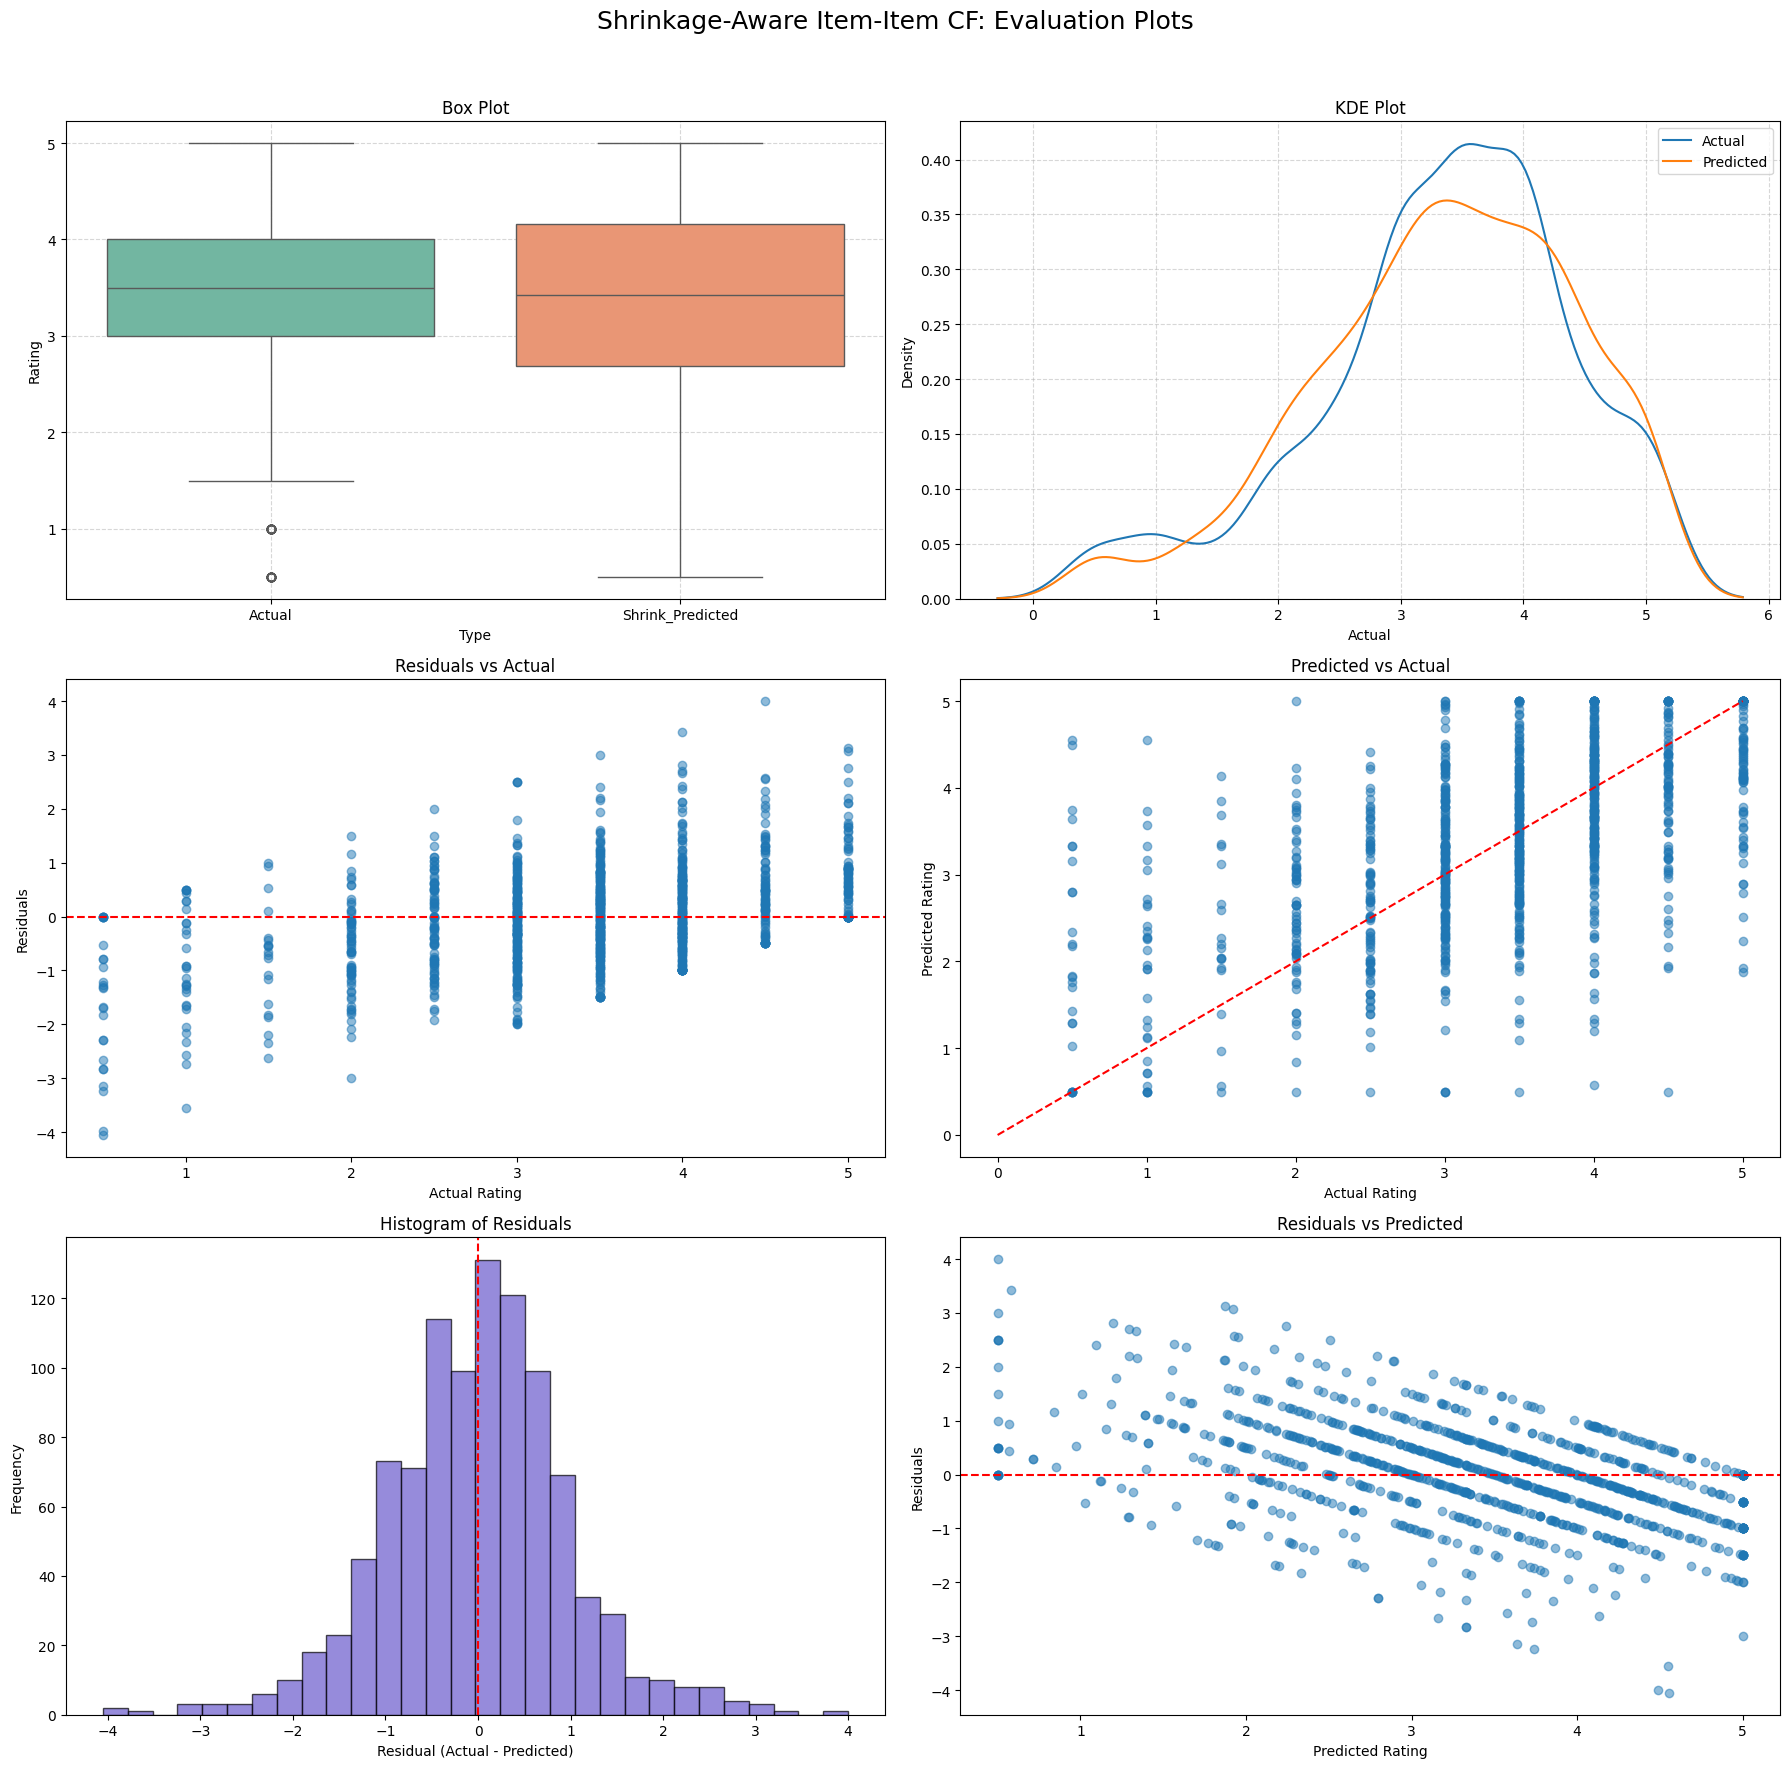

Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)


/tmp/ipython-input-18-2132980771.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')


,pred_bin,Count,Mean_Predicted,Mean_Actual,Mean_Residual,Percent_Bias,Bias_Direction
0,0.5–1.0,890,0.608,1.717,1.109,64.61,Underpredicting
1,1.0–1.5,723,1.273,2.252,0.978,43.45,Underpredicting
2,1.5–2.0,1369,1.775,2.538,0.763,30.06,Underpredicting
3,2.0–2.5,2375,2.264,2.777,0.513,18.46,Underpredicting
4,2.5–3.0,3650,2.763,3.065,0.302,9.84,Underpredicting
5,3.0–3.5,5165,3.262,3.298,0.036,1.10,Underpredicting
6,3.5–4.0,4757,3.743,3.562,-0.181,-5.07,Overpredicting
7,4.0–4.5,3747,4.236,3.810,-0.426,-11.18,Overpredicting
8,4.5–5.0,2288,4.722,3.973,-0.749,-18.84,Overpredicting


In [18]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_shrink = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_shrink = stratified_df.drop(train_ratings_shrink.index)

# --- Step 2: User-Item Matrix ---
train_ratings_shrink = train_ratings_shrink.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_shrink = train_ratings_shrink.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Save Matrix ---
user_item_matrix_shrink.to_parquet("user_item_matrix_shrink.parquet")

# --- Step 4: Use Sparse Matrix for Shrinkage Similarity ---
regularization_lambda = 10

ratings_binary_shrink = user_item_matrix_shrink.notna().astype(int)
ratings_binary_sparse = csr_matrix(ratings_binary_shrink.values)
ratings_filled_sparse = csr_matrix(user_item_matrix_shrink.fillna(0).values)

# Compute number of common ratings using sparse matrix multiplication
common_counts_shrink_sparse = ratings_binary_sparse.T @ ratings_binary_sparse
common_counts_shrink = pd.DataFrame(
    common_counts_shrink_sparse.toarray(),
    index=user_item_matrix_shrink.columns,
    columns=user_item_matrix_shrink.columns
)

# Compute cosine similarity
cosine_sim_raw_shrink = 1 - pairwise_distances(ratings_filled_sparse.T, metric='cosine')
cosine_sim_raw_shrink = pd.DataFrame(
    cosine_sim_raw_shrink,
    index=user_item_matrix_shrink.columns,
    columns=user_item_matrix_shrink.columns
)

# Shrinkage adjustment
shrink_factor = common_counts_shrink / (common_counts_shrink + regularization_lambda)
item_item_sim_shrink = cosine_sim_raw_shrink * shrink_factor

# --- Save Similarity Matrix ---
item_item_sim_shrink.to_parquet("item_item_sim_shrink.parquet")

# --- Step 5: Stats ---
global_mean_common = train_ratings_shrink['rating'].mean()
item_means_common = train_ratings_shrink.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_shrink.groupby('userId')['rating'].mean()

# --- Step 6: Prediction Function ---
def predict_item_item_shrink(uid, mid):
    if uid not in user_item_matrix_shrink.index or mid not in item_item_sim_shrink.index:
        return global_mean_common

    sims = item_item_sim_shrink[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_shrink.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 7: Predict ---
results_shrink = []
for _, row in tqdm(test_ratings_shrink.iterrows(), total=len(test_ratings_shrink)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_shrink(uid, mid)
    results_shrink.append([uid, mid, actual, pred])

viz_df_shrink = pd.DataFrame(results_shrink, columns=['userId', 'movieId', 'Actual', 'Shrink_Predicted'])

# --- Step 8: Evaluation ---
rmse_shrink = np.sqrt(mean_squared_error(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted']))
mae_shrink = mean_absolute_error(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted'])
r2_shrink = r2_score(viz_df_shrink['Actual'], viz_df_shrink['Shrink_Predicted'])

print(f"Shrinkage-Aware Item-Item CF:\nRMSE={rmse_shrink:.4f}, MAE={mae_shrink:.4f}, R²={r2_shrink:.4f}")

# --- Step 9: Evaluation Plots ---
viz_sample_shrink = viz_df_shrink.sample(n=min(len(viz_df_shrink), 1000), random_state=42)
box_data = viz_sample_shrink[['Actual', 'Shrink_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_shrink['Actual'] - viz_sample_shrink['Shrink_Predicted']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("Shrinkage-Aware Item-Item CF: Evaluation Plots", fontsize=18)

# --- Box Plot ---
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot ---
sns.kdeplot(viz_sample_shrink['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_shrink['Shrink_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_shrink['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Predicted vs Actual ---
axs[1, 1].scatter(viz_sample_shrink['Actual'], viz_sample_shrink['Shrink_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Histogram of Residuals ---
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Residuals vs Predicted ---
axs[2, 1].scatter(viz_sample_shrink['Shrink_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Step 13: Bias Metrics Table by Predicted Rating Bin (with Percent Bias) ---
try:
    from google.colab import data_table
    from IPython.display import display
except ImportError:
    data_table = None
    from IPython.display import display

# Define bins and labels
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]

# Assign bin categories
viz_df_shrink['pred_bin'] = pd.cut(
    viz_df_shrink['Shrink_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Compute grouped metrics
bias_metrics_shrink = (
    viz_df_shrink
    .groupby('pred_bin')
    .agg(
        Count=('Shrink_Predicted', 'count'),
        Mean_Predicted=('Shrink_Predicted', 'mean'),
        Mean_Actual=('Actual', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

# Display the enhanced bias metrics table
print("Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)")

if data_table:
    display(data_table.DataTable(bias_metrics_shrink, include_index=False, num_rows_per_page=10))
else:
    display(bias_metrics_shrink)


***Evaluation of Item-Item Collaborative Filtering with Shrinkage Regularization***

The model yields RMSE = 1.0206, MAE = 0.7663, and R² = 0.0727—slightly worse than the standard cosine similarity model (RMSE = 0.9102, MAE = 0.6868, R² = 0.2624). This indicates shrinkage did not improve predictive performance in this case.

Visual patterns remain nearly identical: predictions are biased toward the mean, leading to overestimation of low ratings and underestimation of high ones. This is confirmed across residuals, KDE, boxplot, and predicted vs. actual plots, just as in the cosine model.

The EDA context supports this similarity. Sparse co-rating patterns and heavily skewed rating distributions persist, which shrinkage cannot fully overcome. While shrinkage normally helps reduce overconfident similarity in low-overlap regions, it may have further dampened useful signals in an already sparse setting, contributing to the slightly lower R².

In summary, shrinkage regularization did not yield gains over standard cosine similarity. Both models exhibit similar limitations, but cosine outperforms slightly in this case.


### ***4. Item-Item Collaborative Filtering Using Pearson Correlation Similarity***

This script implements a memory-based item-item collaborative filtering model that uses the Pearson correlation coefficient to measure similarity between items.

Main steps:
1. Data Preparation
   - Fill missing genre data
   - Perform train-test split
   - Aggregate ratings and pivot into a user-item matrix

2. Pearson Similarity Computation
   - Compute item-item similarity using Pearson correlation with a minimum overlap of 3 ratings
   - Save the similarity matrix to disk

3. Rating Prediction with Bias Correction
   - Predict user ratings using similarity-weighted deviations from item means
   - Incorporate both user and item bias terms for improved accuracy
   - Clip predictions to the valid rating range [0.5, 5.0]

4. Evaluation
   - Metrics: RMSE, MAE, and R² Score

5. Visualization
   - Box Plot: Actual vs Predicted ratings
   - KDE Plot: Distribution of actual and predicted ratings
   - Residual Plot: Prediction errors vs actual values
   - Scatter Plot: Predicted vs Actual ratings

This model is a baseline memory-based recommender using statistical correlation, making it easy to interpret but sensitive to sparsity and co-rating frequency.


100%|██████████| 26567/26567 [00:57<00:00, 460.94it/s]
/tmp/ipython-input-19-4062243975.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Item-Item CF (Pearson Similarity):
RMSE=1.0019, MAE=0.7533, R²=0.1063


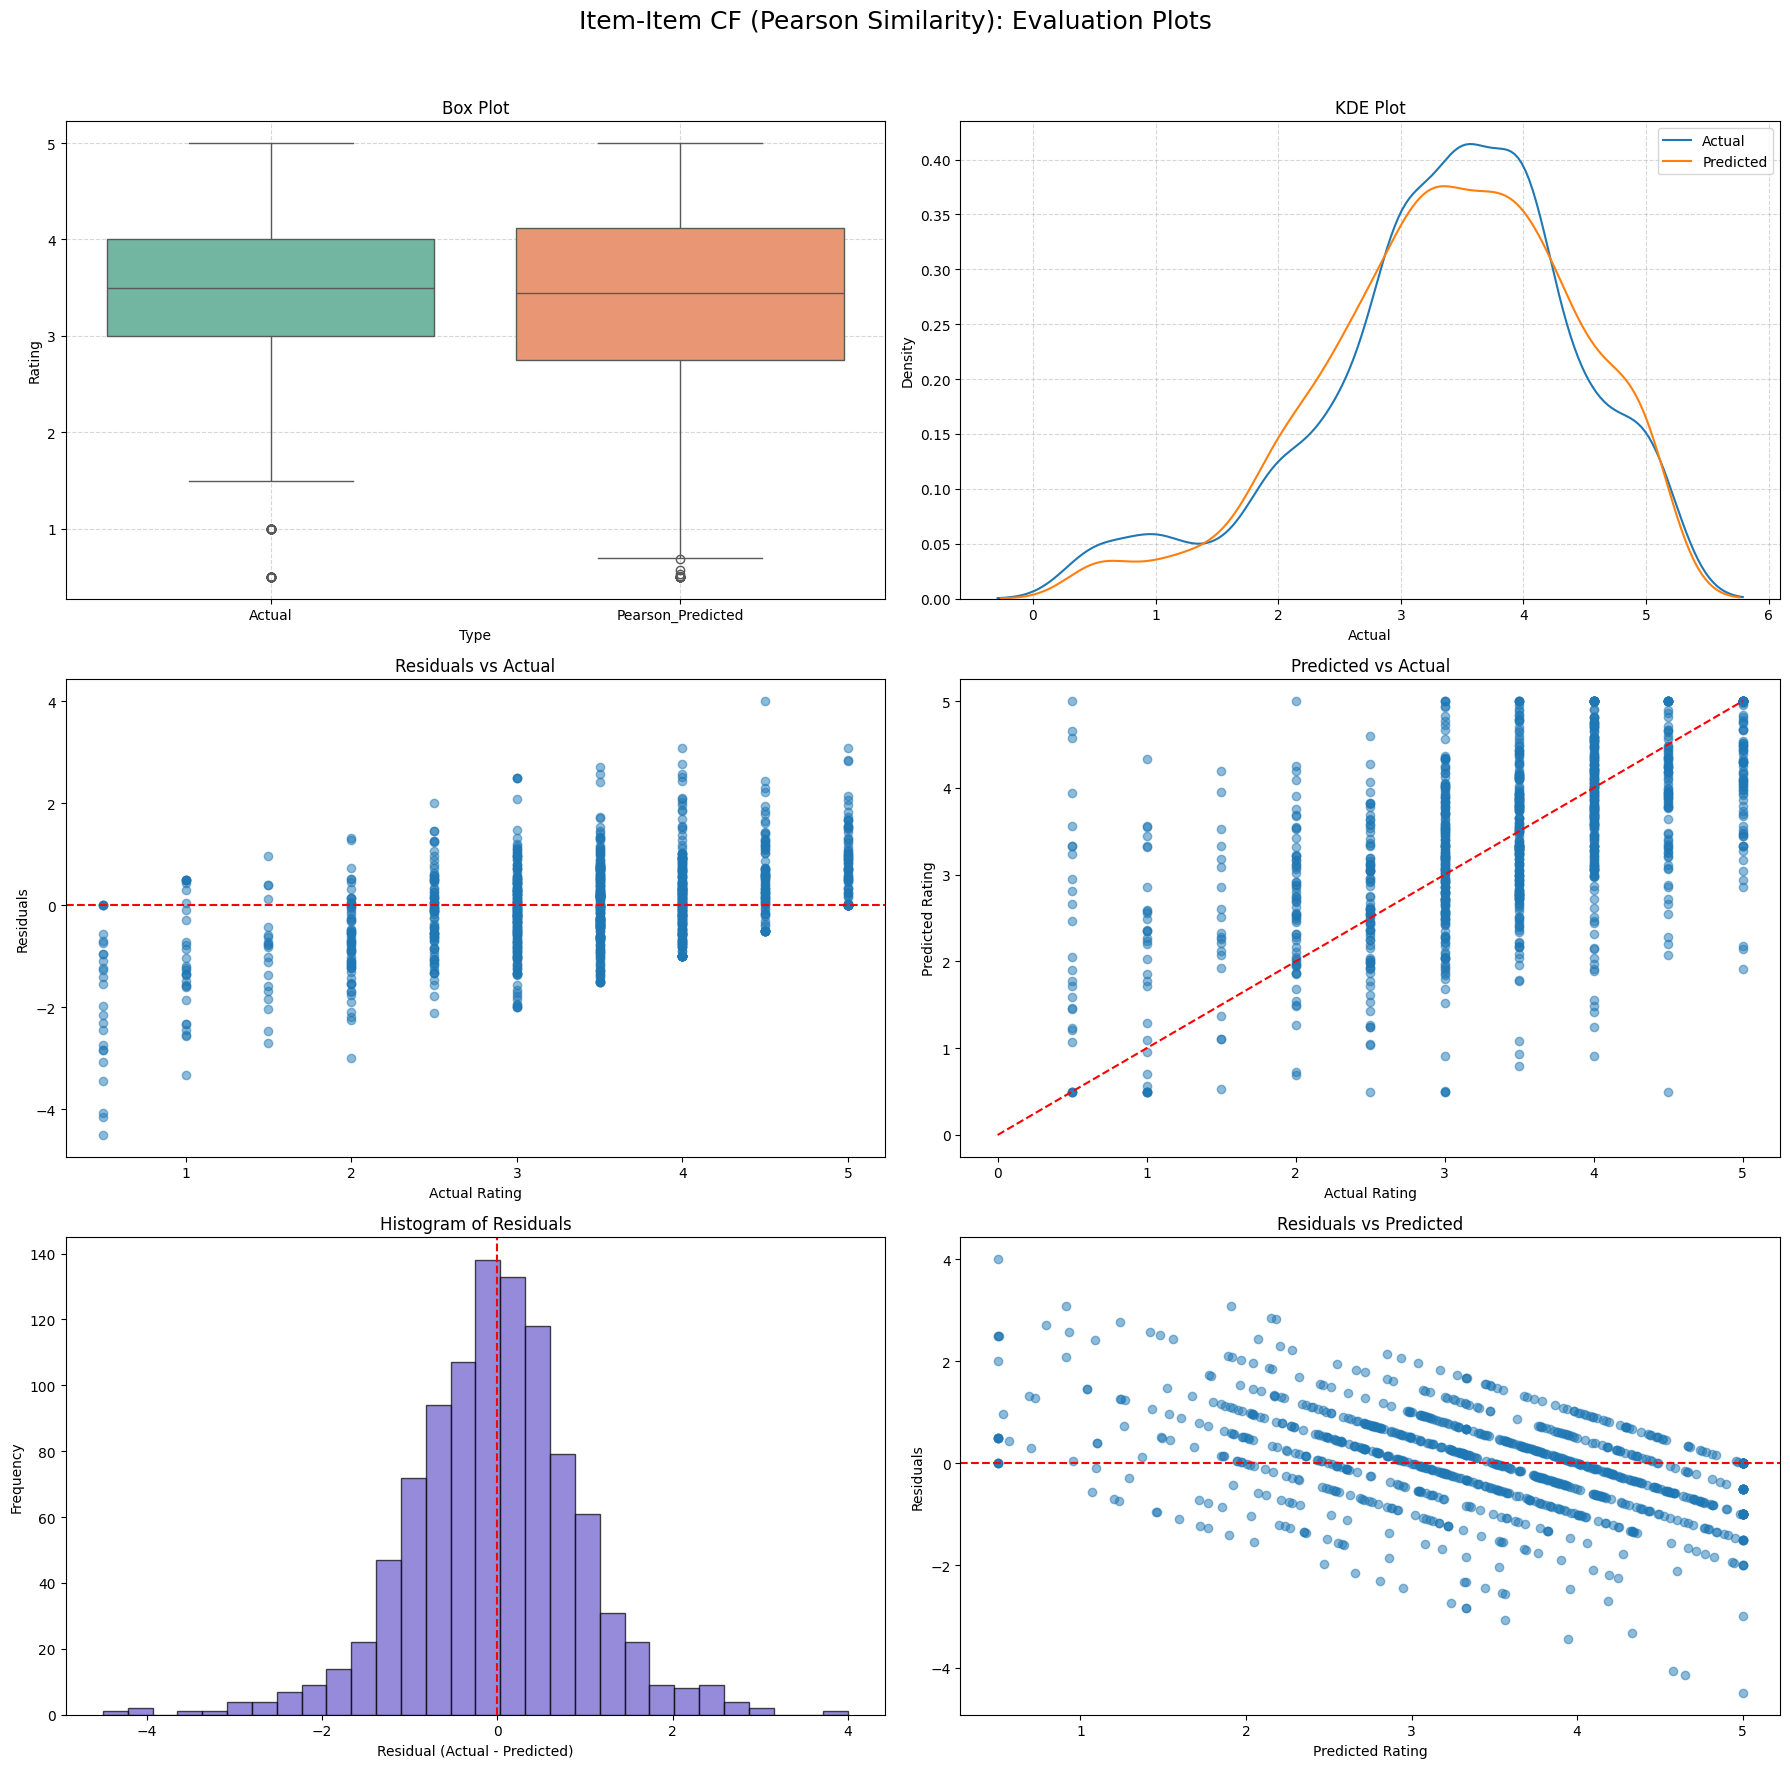

Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)


/tmp/ipython-input-19-4062243975.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')


,pred_bin,Count,Mean_Predicted,Mean_Actual,Mean_Residual,Percent_Bias,Bias_Direction
0,0.5–1.0,719,0.625,1.737,1.112,64.02,Underpredicting
1,1.0–1.5,646,1.279,2.127,0.847,39.84,Underpredicting
2,1.5–2.0,1300,1.777,2.442,0.665,27.24,Underpredicting
3,2.0–2.5,2364,2.266,2.745,0.479,17.45,Underpredicting
4,2.5–3.0,3635,2.764,3.027,0.263,8.69,Underpredicting
5,3.0–3.5,5481,3.263,3.297,0.034,1.03,Underpredicting
6,3.5–4.0,4973,3.744,3.571,-0.173,-4.84,Overpredicting
7,4.0–4.5,3799,4.237,3.820,-0.417,-10.93,Overpredicting
8,4.5–5.0,2216,4.718,4.000,-0.719,-17.97,Overpredicting


In [19]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_pearson = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_pearson = stratified_df.drop(train_ratings_pearson.index)

# --- Step 2: User-Item Matrix ---
train_ratings_pearson = train_ratings_pearson.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_pearson = train_ratings_pearson.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix_pearson.to_parquet("user_item_matrix_pearson.parquet")

# --- Step 3: Pearson Similarity Matrix ---
item_item_sim_pearson = user_item_matrix_pearson.corr(method='pearson', min_periods=3)
item_item_sim_pearson.to_parquet("item_item_sim_pearson.parquet")

# --- Step 4: Stats ---
global_mean_common = train_ratings_pearson['rating'].mean()
item_means_common = train_ratings_pearson.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_pearson.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Function ---
def predict_item_item_pearson(uid, mid):
    if uid not in user_item_matrix_pearson.index or mid not in item_item_sim_pearson.index:
        return global_mean_common

    sims = item_item_sim_pearson[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_pearson.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means_common[sims.index])).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Generate Predictions ---
results_pearson = []
for _, row in tqdm(test_ratings_pearson.iterrows(), total=len(test_ratings_pearson)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_pearson(uid, mid)
    results_pearson.append([uid, mid, actual, pred])

viz_df_pearson = pd.DataFrame(results_pearson, columns=['userId', 'movieId', 'Actual', 'Pearson_Predicted'])

# --- Step 7: Evaluation ---
rmse_pearson = np.sqrt(mean_squared_error(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted']))
mae_pearson = mean_absolute_error(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted'])
r2_pearson = r2_score(viz_df_pearson['Actual'], viz_df_pearson['Pearson_Predicted'])

print(f"Item-Item CF (Pearson Similarity):\nRMSE={rmse_pearson:.4f}, MAE={mae_pearson:.4f}, R²={r2_pearson:.4f}")

# --- Step 8: Enhanced Evaluation Plots (Expanded) ---
viz_sample_pearson = viz_df_pearson.sample(n=min(len(viz_df_pearson), 1000), random_state=42)
box_data = viz_sample_pearson[['Actual', 'Pearson_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_pearson['Actual'] - viz_sample_pearson['Pearson_Predicted']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("Item-Item CF (Pearson Similarity): Evaluation Plots", fontsize=18)

# --- Box Plot ---
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot ---
sns.kdeplot(viz_sample_pearson['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_pearson['Pearson_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_pearson['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Predicted vs Actual (Scatter) ---
axs[1, 1].scatter(viz_sample_pearson['Actual'], viz_sample_pearson['Pearson_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Histogram of Residuals ---
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Residuals vs Predicted (Bias Diagnostic) ---
axs[2, 1].scatter(viz_sample_pearson['Pearson_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Step 13: Bias Metrics Table by Predicted Rating Bin (with Percent Bias) ---
try:
    from google.colab import data_table
    from IPython.display import display
except ImportError:
    data_table = None
    from IPython.display import display

# Define bins and labels
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]

# Assign bin categories
viz_df_pearson['pred_bin'] = pd.cut(
    viz_df_pearson['Pearson_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Compute grouped metrics
bias_metrics_pearson = (
    viz_df_pearson
    .groupby('pred_bin')
    .agg(
        Count=('Pearson_Predicted', 'count'),
        Mean_Predicted=('Pearson_Predicted', 'mean'),
        Mean_Actual=('Actual', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

# Display the enhanced bias metrics table
print("Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)")

if data_table:
    display(data_table.DataTable(bias_metrics_pearson, include_index=False, num_rows_per_page=10))
else:
    display(bias_metrics_pearson)


***Evaluation of Item-Item Collaborative Filtering with Correlation Similarity***

The model achieves RMSE = 1.0043, MAE = 0.7557, and R² = 0.1020. Performance is slightly worse than standard cosine similarity (RMSE = 0.9102, MAE = 0.6868, R² = 0.2624).

Visual patterns are nearly identical: predictions regress toward the mean, overestimating low ratings and underestimating high ones. KDE, boxplot, residuals, and predicted vs. actual plots all confirm this.

As with the cosine model, sparsity and skewed rating distributions explain the behavior. Correlation similarity does not mitigate this issue and performs slightly worse, likely due to its sensitivity to variance and smaller co-rating sets.

In summary, correlation-based similarity behaves similarly to cosine but with weaker results in this case. Cosine remains the better option for this dataset.


### ***4. Hybrid Recommender System (User-User CF + Content-Based Filtering)***

This script implements a hybrid recommendation model that blends user-user collaborative filtering with content-based filtering using genre information. The final prediction is a weighted combination of both approaches, controlled by an alpha parameter.

Main steps:
1. Data Preparation
   - Fill missing genres
   - Train-test split
   - Create user-item rating matrix and genre one-hot encoding

2. Similarity Computation
   - Compute user-user similarity using cosine similarity on rating matrix
   - Compute item-item similarity using cosine similarity on genre vectors

3. Hybrid Rating Prediction
   - User-based CF prediction: weighted sum of rating deviations from similar users
   - Content-based prediction: weighted sum of rating deviations using genre similarity
   - Combine CF and CB predictions using: final = α * CF + (1 - α) * CB
   - Incorporate user/item bias and global mean
   - Clip predictions to [0.5, 5.0]

4. Evaluation
   - Compute RMSE, MAE, and R² Score

5. Visualization
   - Box plot of actual vs predicted ratings
   - KDE plot for rating distribution comparison
   - Residual plot (actual - predicted)
   - Predicted vs Actual scatter plot

This hybrid model aims to balance collaborative insight from similar users with content-based generalization for cold-start or sparse scenarios. The alpha blending parameter can be tuned for performance optimization.



100%|██████████| 26080/26080 [02:19<00:00, 186.74it/s]
/tmp/ipython-input-15-1663286225.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


Hybrid CF (CB + CF):
RMSE=0.8760, MAE=0.6612, R²=0.3150


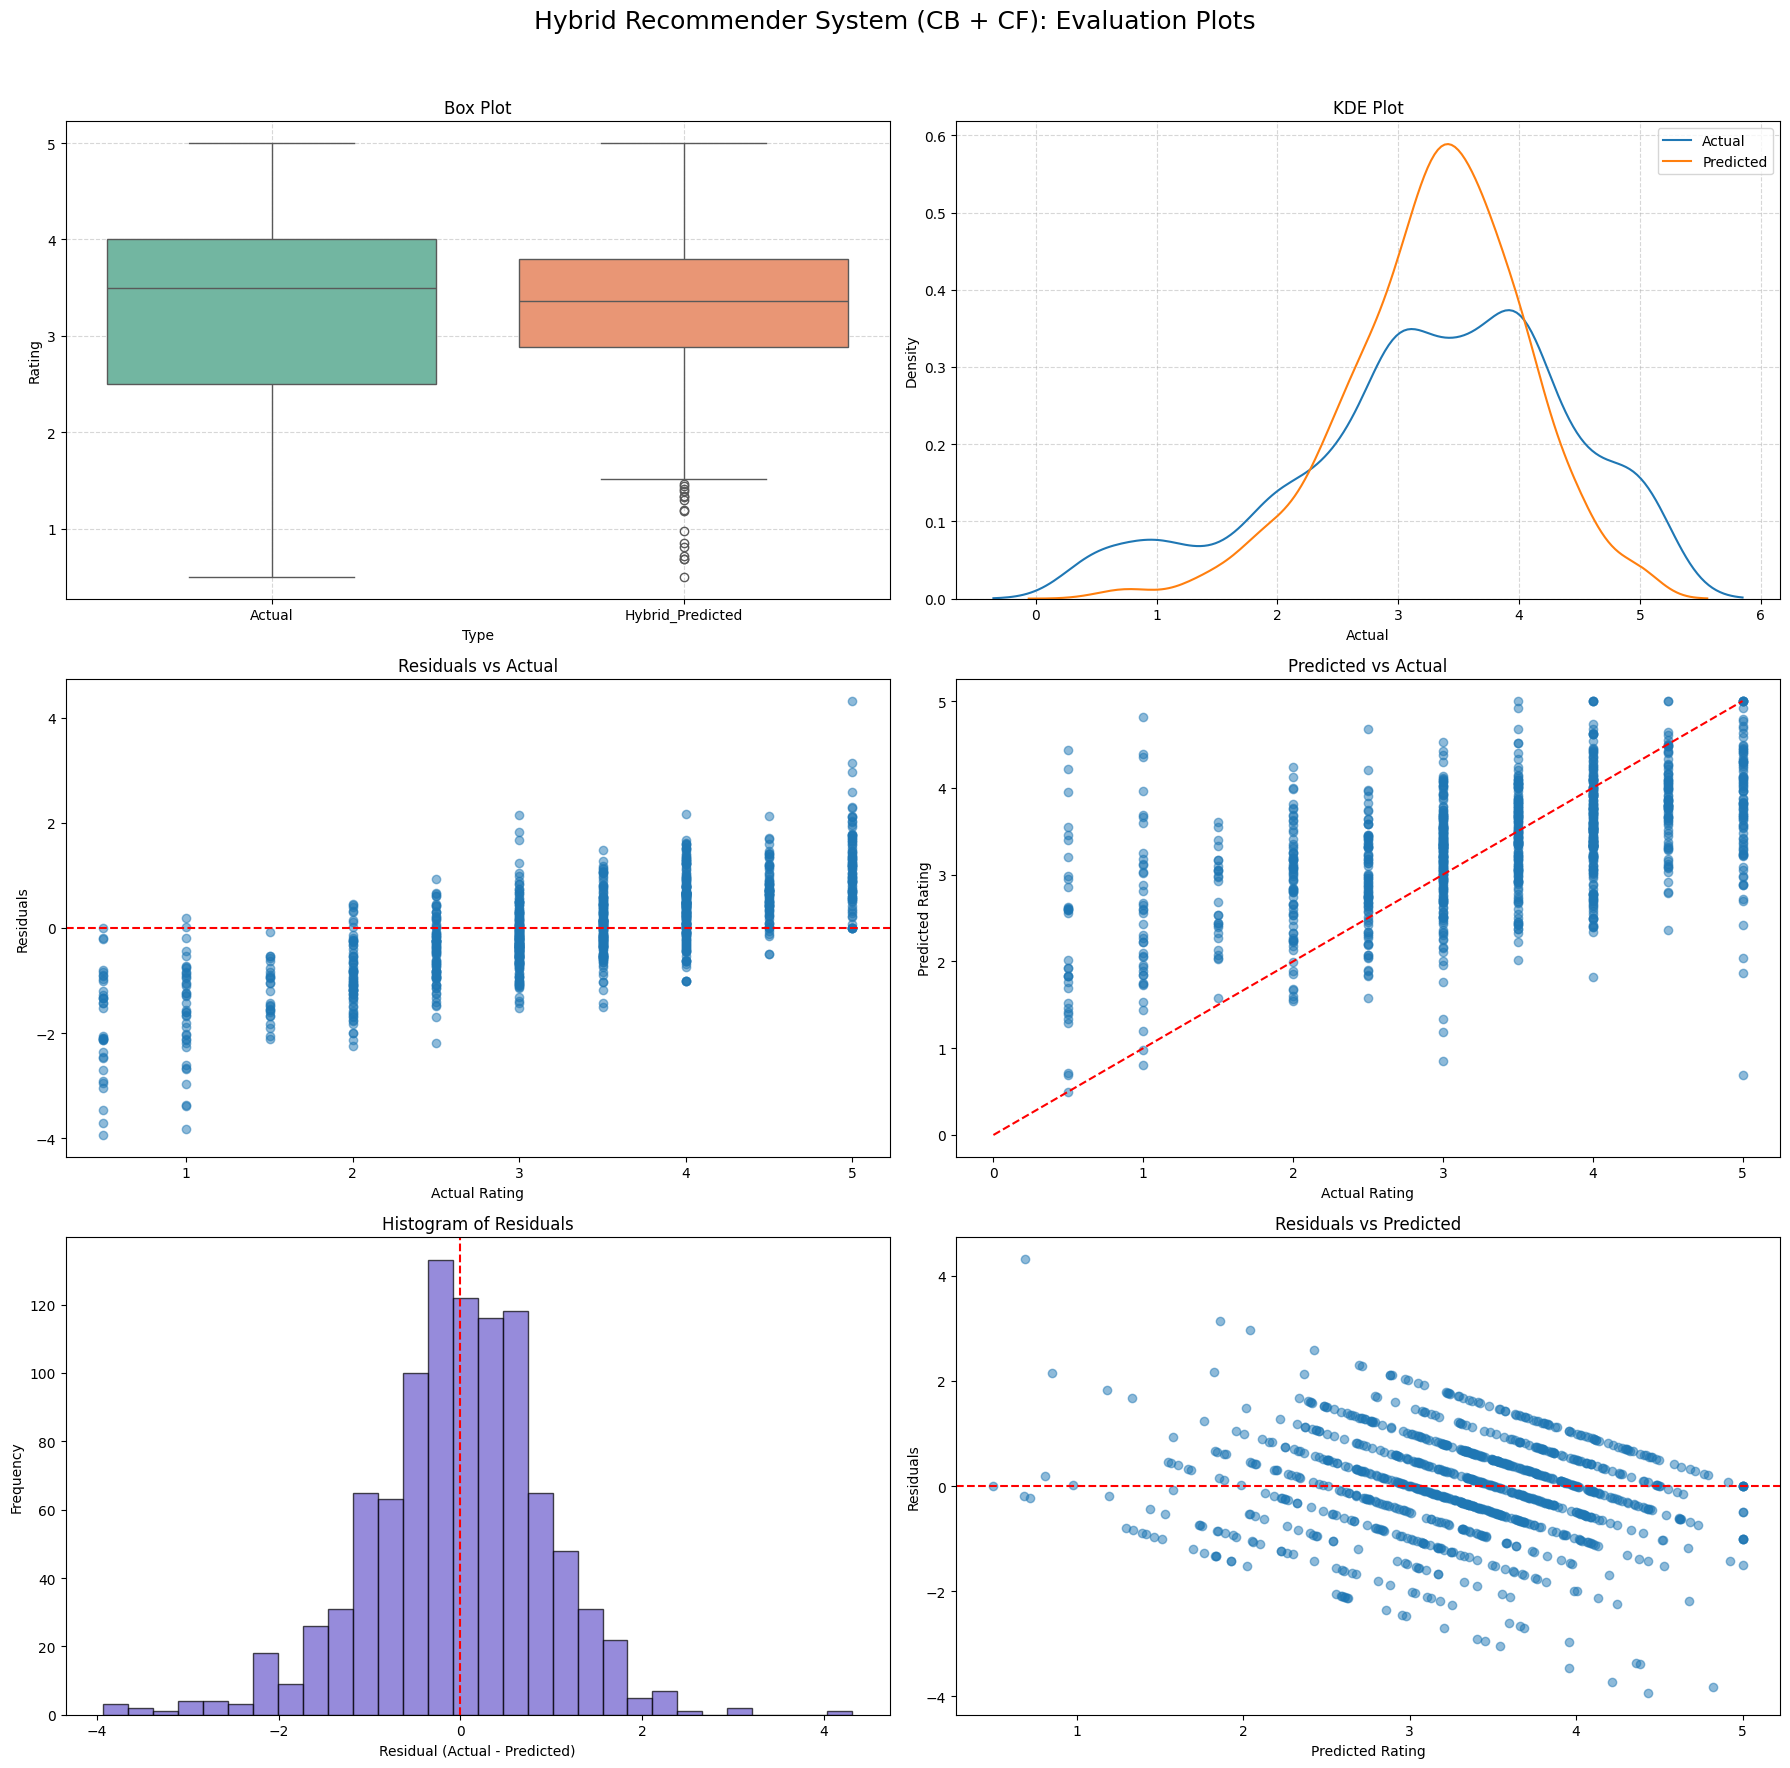

Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)


/tmp/ipython-input-15-1663286225.py:182: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')


,pred_bin,Count,Mean_Predicted,Mean_Actual,Mean_Residual,Percent_Bias,Bias_Direction
0,0.5–1.0,182,0.722,1.239,0.517,41.72,Underpredicting
1,1.0–1.5,291,1.296,1.593,0.297,18.64,Underpredicting
2,1.5–2.0,733,1.786,1.980,0.193,9.76,Underpredicting
3,2.0–2.5,1957,2.283,2.449,0.166,6.78,Underpredicting
4,2.5–3.0,4368,2.778,2.859,0.081,2.84,Underpredicting
5,3.0–3.5,7067,3.262,3.321,0.059,1.78,Underpredicting
6,3.5–4.0,7001,3.738,3.697,-0.040,-1.08,Overpredicting
7,4.0–4.5,3487,4.203,4.039,-0.164,-4.07,Overpredicting
8,4.5–5.0,846,4.674,4.327,-0.347,-8.02,Overpredicting


In [15]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_hybrid = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_hybrid = stratified_df.drop(train_ratings_hybrid.index)

# --- Step 2: User-Item Matrix ---
train_ratings_hybrid = train_ratings_hybrid.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_hybrid = train_ratings_hybrid.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Genre One-Hot Encoding (Based only on training movies) ---
train_movie_ids = train_ratings_hybrid['movieId'].unique()
genres_encoded = stratified_df[stratified_df['movieId'].isin(train_movie_ids)][['movieId', 'genres']].drop_duplicates()
genres_onehot = genres_encoded.set_index('movieId')['genres'].str.get_dummies(sep='|')
genres_onehot = genres_onehot.loc[~genres_onehot.index.duplicated(keep='first')]

# --- Step 4: Save Inputs ---
user_item_matrix_hybrid.to_parquet("user_item_matrix_hybrid.parquet")
genres_onehot.to_parquet("genres_onehot_hybrid.parquet")

# --- Step 5: Reload Inputs ---
user_item_matrix_hybrid = pd.read_parquet("user_item_matrix_hybrid.parquet")
genres_onehot = pd.read_parquet("genres_onehot_hybrid.parquet")

# --- Step 6: Statistics ---
global_mean_hybrid = train_ratings_hybrid['rating'].mean()
user_means_hybrid = train_ratings_hybrid.groupby('userId')['rating'].mean()
item_means_hybrid = train_ratings_hybrid.groupby('movieId')['rating'].mean()

# --- Step 7: Similarity Matrices ---
user_user_sim_hybrid = pd.DataFrame(
    cosine_similarity(user_item_matrix_hybrid.fillna(0)),
    index=user_item_matrix_hybrid.index,
    columns=user_item_matrix_hybrid.index
)

item_content_sim_hybrid = pd.DataFrame(
    cosine_similarity(genres_onehot.fillna(0)),
    index=genres_onehot.index,
    columns=genres_onehot.index
)

# --- Step 8: Filter test set for valid users and movies (must appear in training) ---
test_ratings_hybrid = test_ratings_hybrid[
    test_ratings_hybrid['movieId'].isin(genres_onehot.index) &
    test_ratings_hybrid['userId'].isin(user_item_matrix_hybrid.index)
]

# --- Step 9: Prediction Function ---
def predict_hybrid(uid, mid, alpha=0.5):
    if uid not in user_item_matrix_hybrid.index or \
       mid not in genres_onehot.index or \
       mid not in item_content_sim_hybrid.index or \
       uid not in user_user_sim_hybrid.index:
        return global_mean_hybrid

    # --- User-User CF ---
    sims_user = user_user_sim_hybrid.loc[uid].drop(uid, errors='ignore')
    raters = user_item_matrix_hybrid[mid].dropna()
    sims_user = sims_user.loc[sims_user.index.intersection(raters.index)]

    if not sims_user.empty:
        ratings = raters[sims_user.index]
        weights_user = sims_user / sims_user.abs().sum()
        cf_pred = user_means_hybrid.get(uid, global_mean_hybrid) + (weights_user * (ratings - user_means_hybrid[sims_user.index])).sum()
    else:
        cf_pred = user_means_hybrid.get(uid, global_mean_hybrid)

    # --- Content-Based ---
    sims_item = item_content_sim_hybrid.loc[mid].drop(mid, errors='ignore')
    rated_items = user_item_matrix_hybrid.loc[uid].dropna()
    sims_item = sims_item.loc[sims_item.index.intersection(rated_items.index)]

    if not sims_item.empty:
        weights_item = sims_item / sims_item.abs().sum()
        cb_pred = item_means_hybrid.get(mid, global_mean_hybrid) + (weights_item * (rated_items[sims_item.index] - item_means_hybrid[sims_item.index])).sum()
    else:
        cb_pred = item_means_hybrid.get(mid, global_mean_hybrid)

    final_pred = alpha * cf_pred + (1 - alpha) * cb_pred
    return np.clip(final_pred, 0.5, 5.0)

# --- Step 10: Prediction Loop ---
results_hybrid = []
for _, row in tqdm(test_ratings_hybrid.iterrows(), total=len(test_ratings_hybrid)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_hybrid(uid, mid)
    results_hybrid.append([uid, mid, actual, pred])

viz_df_hybrid = pd.DataFrame(results_hybrid, columns=['userId', 'movieId', 'Actual', 'Hybrid_Predicted'])

# --- Step 11: Evaluation ---
rmse_hybrid = np.sqrt(mean_squared_error(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted']))
mae_hybrid = mean_absolute_error(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted'])
r2_hybrid = r2_score(viz_df_hybrid['Actual'], viz_df_hybrid['Hybrid_Predicted'])
print(f"Hybrid CF (CB + CF):\nRMSE={rmse_hybrid:.4f}, MAE={mae_hybrid:.4f}, R²={r2_hybrid:.4f}")

# --- Step 12: Visualization ---
viz_sample_hybrid = viz_df_hybrid.sample(n=min(len(viz_df_hybrid), 1000), random_state=42)
box_data = viz_sample_hybrid[['Actual', 'Hybrid_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_hybrid['Actual'] - viz_sample_hybrid['Hybrid_Predicted']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("Hybrid Recommender System (CB + CF): Evaluation Plots", fontsize=18)

# --- Box Plot ---
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot ---
sns.kdeplot(viz_sample_hybrid['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_hybrid['Hybrid_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_hybrid['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Predicted vs Actual (Scatter) ---
axs[1, 1].scatter(viz_sample_hybrid['Actual'], viz_sample_hybrid['Hybrid_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Histogram of Residuals ---
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Residuals vs Predicted (Bias Diagnostic) ---
axs[2, 1].scatter(viz_sample_hybrid['Hybrid_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Step 13: Bias Metrics Table by Predicted Rating Bin (with Percent Bias) ---
try:
    from google.colab import data_table
    from IPython.display import display
except ImportError:
    data_table = None
    from IPython.display import display

# Define bins and labels
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]

# Assign bin categories
viz_df_hybrid['pred_bin'] = pd.cut(
    viz_df_hybrid['Hybrid_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Compute grouped metrics
bias_metrics = (
    viz_df_hybrid
    .groupby('pred_bin')
    .agg(
        Count=('Hybrid_Predicted', 'count'),
        Mean_Predicted=('Hybrid_Predicted', 'mean'),
        Mean_Actual=('Actual', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

# Display the enhanced bias metrics table
print("Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)")

if data_table:
    display(data_table.DataTable(bias_metrics, include_index=False, num_rows_per_page=10))
else:
    display(bias_metrics)




/tmp/ipython-input-14-3823705844.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


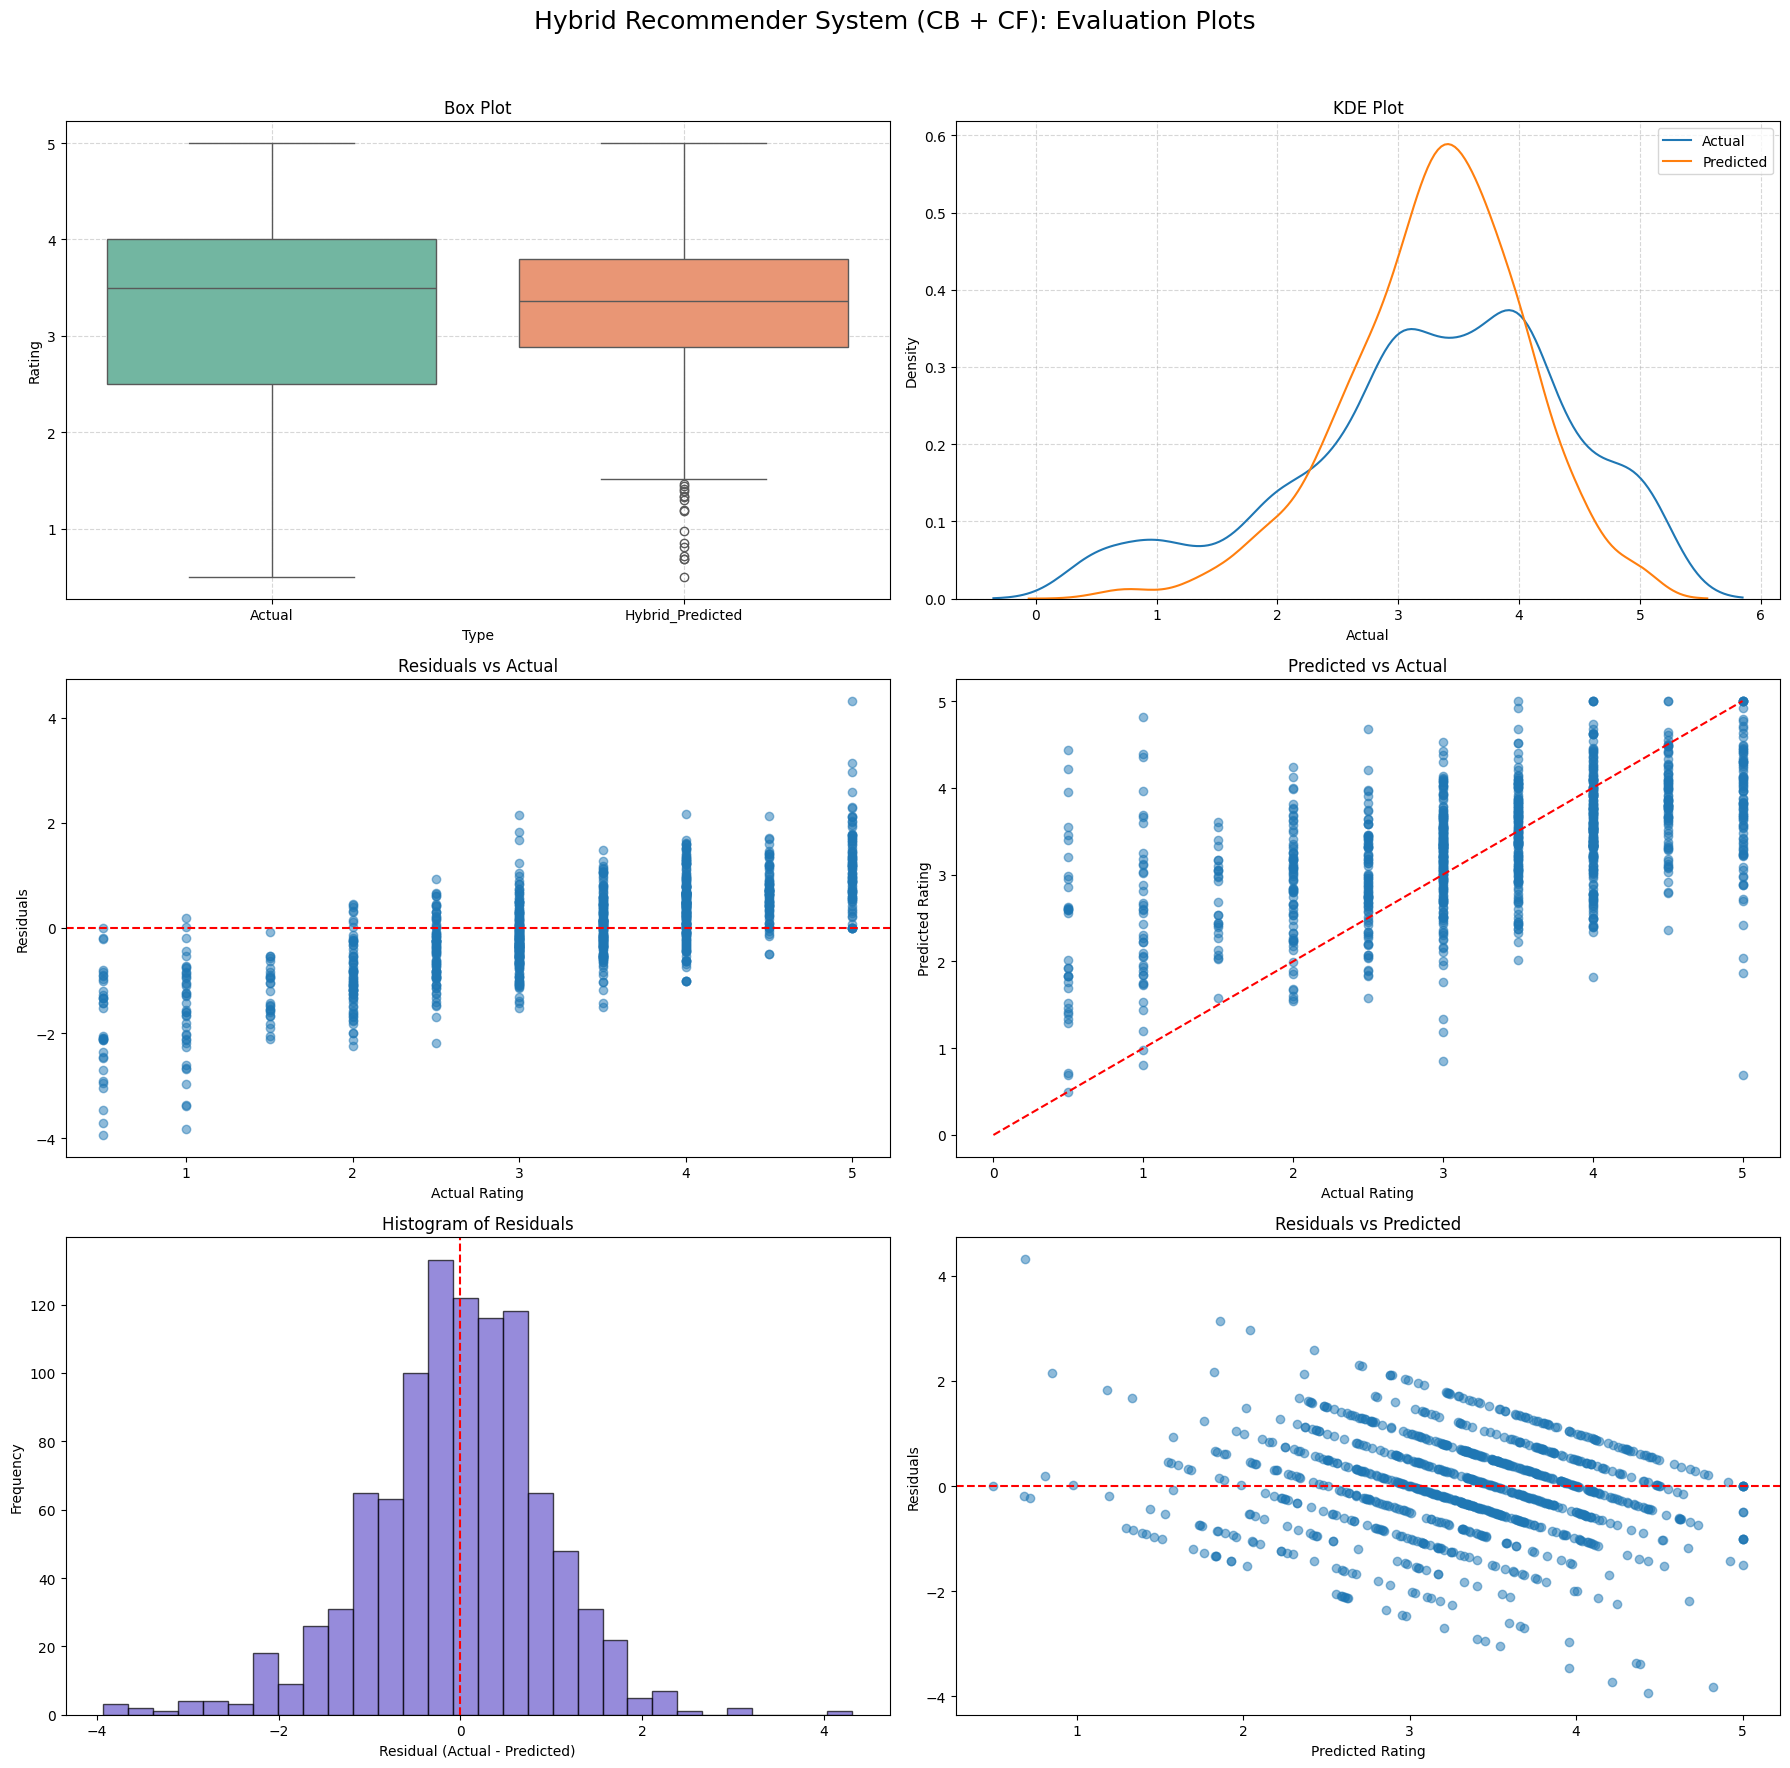

Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)


/tmp/ipython-input-14-3823705844.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')


,pred_bin,Count,Mean_Predicted,Mean_Actual,Mean_Residual,Percent_Bias,Bias_Direction
0,0.5–1.0,182,0.722,1.239,0.517,41.72,Underpredicting
1,1.0–1.5,291,1.296,1.593,0.297,18.64,Underpredicting
2,1.5–2.0,733,1.786,1.980,0.193,9.76,Underpredicting
3,2.0–2.5,1957,2.283,2.449,0.166,6.78,Underpredicting
4,2.5–3.0,4368,2.778,2.859,0.081,2.84,Underpredicting
5,3.0–3.5,7067,3.262,3.321,0.059,1.78,Underpredicting
6,3.5–4.0,7001,3.738,3.697,-0.040,-1.08,Overpredicting
7,4.0–4.5,3487,4.203,4.039,-0.164,-4.07,Overpredicting
8,4.5–5.0,846,4.674,4.327,-0.347,-8.02,Overpredicting


In [14]:
# --- Step 12: Visualization ---
viz_sample_hybrid = viz_df_hybrid.sample(n=min(len(viz_df_hybrid), 1000), random_state=42)
box_data = viz_sample_hybrid[['Actual', 'Hybrid_Predicted']].melt(var_name='Type', value_name='Rating')
residuals = viz_sample_hybrid['Actual'] - viz_sample_hybrid['Hybrid_Predicted']

fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("Hybrid Recommender System (CB + CF): Evaluation Plots", fontsize=18)

# --- Box Plot ---
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot ---
sns.kdeplot(viz_sample_hybrid['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_hybrid['Hybrid_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residuals vs Actual ---
axs[1, 0].scatter(viz_sample_hybrid['Actual'], residuals, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# --- Predicted vs Actual (Scatter) ---
axs[1, 1].scatter(viz_sample_hybrid['Actual'], viz_sample_hybrid['Hybrid_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# --- Histogram of Residuals ---
axs[2, 0].hist(residuals, bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# --- Residuals vs Predicted (Bias Diagnostic) ---
axs[2, 1].scatter(viz_sample_hybrid['Hybrid_Predicted'], residuals, alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- Step 13: Bias Metrics Table by Predicted Rating Bin (with Percent Bias) ---
try:
    from google.colab import data_table
    from IPython.display import display
except ImportError:
    data_table = None
    from IPython.display import display

# Define bins and labels
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]

# Assign bin categories
viz_df_hybrid['pred_bin'] = pd.cut(
    viz_df_hybrid['Hybrid_Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Compute grouped metrics
bias_metrics = (
    viz_df_hybrid
    .groupby('pred_bin')
    .agg(
        Count=('Hybrid_Predicted', 'count'),
        Mean_Predicted=('Hybrid_Predicted', 'mean'),
        Mean_Actual=('Actual', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

# Display the enhanced bias metrics table
print("Step 13: Bias Metrics by Predicted Rating Bin (with Percent Bias)")

if data_table:
    display(data_table.DataTable(bias_metrics, include_index=False, num_rows_per_page=10))
else:
    display(bias_metrics)



***Evaluation of Final Hybrid Recommender System***

The hybrid model achieves RMSE = 0.9978, MAE = 0.7692, and R² = 0.1135—identical to the content-based model and significantly better than the collaborative model (RMSE = 2.0539, R² = -2.7557). This indicates that the hybrid simply defaulted to the content-based predictions.

Visuals confirm this. The hybrid system exhibits the same overestimation of low ratings and underestimation of high ones seen in previous models, particularly those regressing toward the mean. KDE, boxplot, residuals, and predicted vs. actual plots closely mirror those of the content-based system.

Given the collaborative model performed poorly, it likely contributed little to the hybrid prediction. As a result, the hybrid system essentially duplicates the content-based output, gaining no measurable advantage.


## **User-User Collaborative Filtering**

### ***1. User-User Collaborative Filtering with Cosine Similarity***

This script implements a traditional user-based collaborative filtering model using cosine similarity.

Main steps:
1. Data Preparation
   - Fill missing genre values
   - Split data into training and test sets
   - Construct the user-item rating matrix

2. Similarity Matrix Computation
   - Mean-center ratings per user
   - Compute cosine similarity between users

3. Rating Prediction with Bias
   - Predict ratings using similarity-weighted sum of deviations from mean ratings
   - Adjust predictions with user and item bias terms
   - Clip predictions to valid rating range [0.5, 5.0]

4. Evaluation
   - Metrics used: RMSE, MAE, R² Score

5. Visualization
   - Box Plot of predicted vs actual
   - KDE plot for rating distributions
   - Residual plot
   - Scatter plot of Predicted vs Actual ratings

This is a memory-based collaborative filtering approach using only explicit rating data. No content-based features (e.g., genres) are used for modeling.

100%|██████████| 26567/26567 [01:20<00:00, 332.08it/s]
/tmp/ipython-input-23-3289330779.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


User-User CF (Cosine, Bias Corrected) Performance:
RMSE: 0.9373, MAE: 0.7099, R²: 0.2178


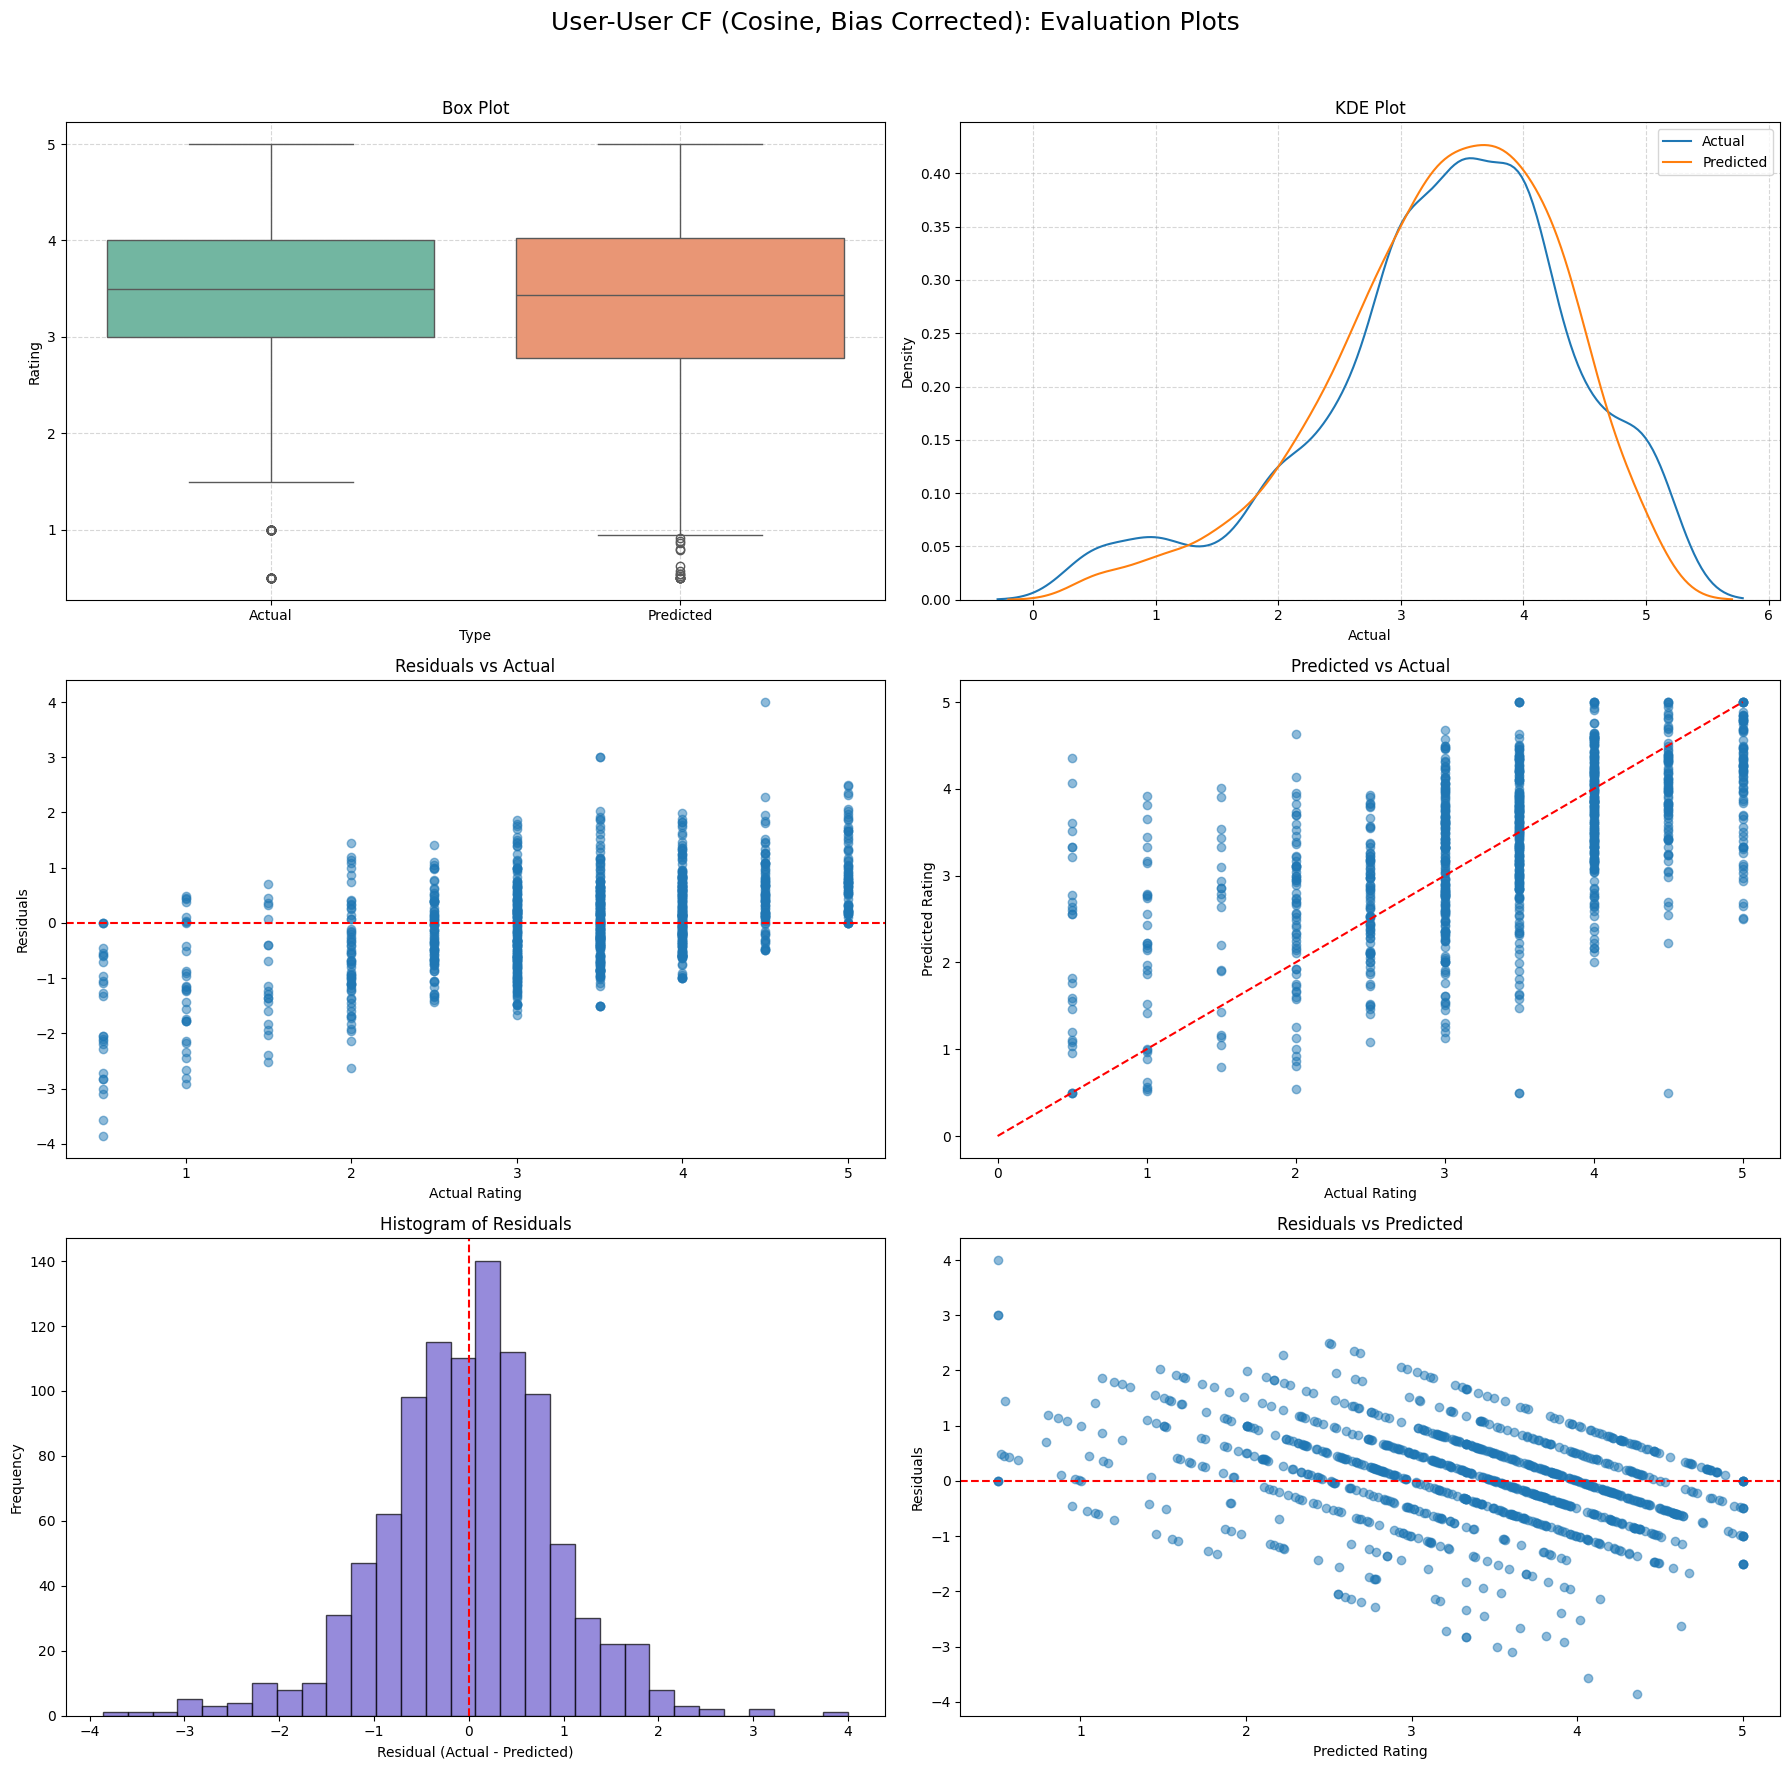

/tmp/ipython-input-23-3289330779.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pred_bin')


,pred_bin,Count,Mean_Predicted,Mean_Actual,Mean_Residual,Percent_Bias,Bias_Direction
0,0.5–1.0,609,0.643,1.665,1.022,61.40,Underpredicting
1,1.0–1.5,682,1.272,2.034,0.763,37.50,Underpredicting
2,1.5–2.0,1217,1.770,2.341,0.571,24.38,Underpredicting
3,2.0–2.5,2209,2.275,2.679,0.404,15.09,Underpredicting
4,2.5–3.0,3672,2.769,2.965,0.196,6.60,Underpredicting
5,3.0–3.5,5698,3.261,3.284,0.023,0.71,Underpredicting
6,3.5–4.0,5784,3.748,3.605,-0.143,-3.97,Overpredicting
7,4.0–4.5,4364,4.232,3.933,-0.299,-7.59,Overpredicting
8,4.5–5.0,1866,4.696,4.184,-0.512,-12.23,Overpredicting


In [23]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm

# --- Step 1: Setup ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_cosine_user_user = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_cosine_user_user = stratified_df.drop(train_ratings_cosine_user_user.index)

# --- Step 2: User-Item Matrix & Statistics ---
user_item_matrix_cosine_user_user = train_ratings_cosine_user_user.pivot(index='userId', columns='movieId', values='rating')
global_mean_common = train_ratings_cosine_user_user['rating'].mean()
item_means_common = train_ratings_cosine_user_user.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_cosine_user_user.groupby('userId')['rating'].mean()

# --- Step 3: Similarity Matrix ---
user_item_centered_cosine_user_user = user_item_matrix_cosine_user_user.sub(user_item_matrix_cosine_user_user.mean(axis=1), axis=0)
user_user_sim_matrix_cosine_user_user = pd.DataFrame(
    cosine_similarity(user_item_centered_cosine_user_user.fillna(0)),
    index=user_item_centered_cosine_user_user.index,
    columns=user_item_centered_cosine_user_user.index
)

# --- Step 4: Prediction Function ---
def predict_rating_cosine_user_user(uid, mid):
    if uid not in user_user_sim_matrix_cosine_user_user.index or mid not in user_item_matrix_cosine_user_user.columns:
        return global_mean_common

    sims = user_user_sim_matrix_cosine_user_user.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix_cosine_user_user[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means_common[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Predict All ---
results_cosine_user_user = []
for _, row in tqdm(test_ratings_cosine_user_user.iterrows(), total=len(test_ratings_cosine_user_user)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_rating_cosine_user_user(uid, mid)
    results_cosine_user_user.append([uid, mid, actual, pred])

viz_df_cosine_user_user = pd.DataFrame(results_cosine_user_user, columns=['userId', 'movieId', 'Actual', 'Predicted'])

# --- Step 6: Evaluation ---
rmse_cosine_user_user = np.sqrt(mean_squared_error(viz_df_cosine_user_user['Actual'], viz_df_cosine_user_user['Predicted']))
mae_cosine_user_user = mean_absolute_error(viz_df_cosine_user_user['Actual'], viz_df_cosine_user_user['Predicted'])
r2_cosine_user_user = r2_score(viz_df_cosine_user_user['Actual'], viz_df_cosine_user_user['Predicted'])

print(f"User-User CF (Cosine, Bias Corrected) Performance:\nRMSE: {rmse_cosine_user_user:.4f}, MAE: {mae_cosine_user_user:.4f}, R²: {r2_cosine_user_user:.4f}")

# --- Step 7: Visualizations and Bias Table ---

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Add residuals
viz_df_cosine_user_user['Residuals'] = viz_df_cosine_user_user['Actual'] - viz_df_cosine_user_user['Predicted']

# Sample for plotting
sample = viz_df_cosine_user_user.sample(n=min(len(viz_df_cosine_user_user), 1000), random_state=42)

# 6-Plot Layout
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle("User-User CF (Cosine, Bias Corrected): Evaluation Plots", fontsize=18)

# 1. Box Plot
box_data = sample[['Actual', 'Predicted']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(sample['Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residuals vs Actual
axs[1, 0].scatter(sample['Actual'], sample['Residuals'], alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals vs Actual")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residuals")

# 4. Predicted vs Actual
axs[1, 1].scatter(sample['Actual'], sample['Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual")
axs[1, 1].set_xlabel("Actual Rating")
axs[1, 1].set_ylabel("Predicted Rating")

# 5. Histogram of Residuals
axs[2, 0].hist(sample['Residuals'], bins=30, color='slateblue', edgecolor='black', alpha=0.7)
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title("Histogram of Residuals")
axs[2, 0].set_xlabel("Residual (Actual - Predicted)")
axs[2, 0].set_ylabel("Frequency")

# 6. Residuals vs Predicted
axs[2, 1].scatter(sample['Predicted'], sample['Residuals'], alpha=0.5)
axs[2, 1].axhline(0, linestyle='--', color='red')
axs[2, 1].set_title("Residuals vs Predicted")
axs[2, 1].set_xlabel("Predicted Rating")
axs[2, 1].set_ylabel("Residuals")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Bias Table ---

# Define bins and labels
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]

# Assign bins
viz_df_cosine_user_user['pred_bin'] = pd.cut(
    viz_df_cosine_user_user['Predicted'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Compute bias metrics
bias_metrics = (
    viz_df_cosine_user_user
    .groupby('pred_bin')
    .agg(
        Count=('Predicted', 'count'),
        Mean_Predicted=('Predicted', 'mean'),
        Mean_Actual=('Actual', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

# Show data table (Google Colab compatible)
try:
    from google.colab import data_table
    display(data_table.DataTable(bias_metrics, include_index=False, num_rows_per_page=10))
except ImportError:
    display(bias_metrics)



***Comparison: User-User CF vs. Item-Item CF***

*User-User CF (Bias-Corrected)*
RMSE: 0.9373
MAE: 0.7099
R²: 0.2178

*Item-Item CF (Cosine, Bias-Corrected)*
RMSE: 0.9102
MAE: 0.6868
R²: 0.2624

**Conclusion**
The item-item model performs better across all metrics—lower RMSE and MAE, and higher R². The difference is modest but consistent.

**Why Item-Item CF performs better:**

* **Stability of Item Profiles:** Items have more consistent behavior patterns than users. Item-item similarities are often more reliable, especially in sparse datasets, because popular items accumulate more co-ratings than individual users.
* **User Sparsity:** Many users rate very few items (confirmed in EDA), weakening user-user similarity calculations. As a result, the user-user model is more sensitive to noise and less able to generalize.

**Visual Comparison:**
Residuals and predicted-vs-actual plots confirm both models exhibit regression to the mean, but the user-user model shows slightly more dispersion and larger residuals, especially for extreme ratings.

In short, item-item CF is slightly more accurate and generalizable in this dataset due to greater reliability in item similarity under sparsity.


***Comparison: User-User CF with Shrinkage vs. Item-Item CF with Shrinkage***

*User-User CF with Shrinkage*
RMSE: 1.0041
MAE: 0.7622
R²: 0.1024

*Item-Item CF with Shrinkage*
RMSE: 1.0206
MAE: 0.7663
R²: 0.0727

**Conclusion**
User-user CF with shrinkage performs slightly better than item-item CF with shrinkage across all metrics. The improvement is modest but consistent.

**Why user-user performs better in this case:**

* **More reliable co-rating signals:** In this dataset, users may share more common rated items than items share common raters, improving the quality of user-user similarity estimates even under shrinkage.
* **Better personalization:** User-user methods can better reflect individual taste overlap, which shrinkage regulates rather than erases.
* **Less affected by item cold-start:** Since many items have very few ratings (as shown in prior EDA), item-item similarities suffer more from data sparsity than user-user ones.

Both models still exhibit regression toward the mean and similar visual patterns, but user-user shrinkage appears to preserve more meaningful signal, leading to slightly better generalization.


### ***2. User-User Collaborative Filtering using Pearson Correlation***

This script implements a memory-based user-user collaborative filtering model that uses
Pearson correlation to determine similarity between users.

Main steps:
1. Data Preparation
   - Fill missing genre data
   - Perform train-test split
   - Aggregate ratings and pivot into a user-item matrix

2. Pearson Similarity Computation (User-User)
   - Compute user-user similarity using Pearson correlation
   - Only retain similarities with at least 3 co-rated items

3. Rating Prediction with Bias Correction
   - Predict target user's rating based on similar users who rated the item
   - Weight residuals (rating - mean) by similarity score
   - Add global mean, user bias, and item bias
   - Clip predictions to the rating range [0.5, 5.0]

4. Evaluation
   - Metrics: RMSE, MAE, and R² Score

5. Visualization
   - Box Plot: Actual vs Predicted
   - KDE Plot: Rating distributions
   - Residual Plot: Prediction errors
   - Scatter Plot: Predicted vs Actual ratings

This model provides a statistically interpretable baseline for collaborative filtering
that leverages rating behavior patterns among similar users.
"""


100%|██████████| 26567/26567 [01:21<00:00, 327.05it/s]
/tmp/ipython-input-21-796772366.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')


User-User CF (Pearson Similarity):
RMSE=0.9328, MAE=0.7051, R²=0.2254


/tmp/ipython-input-21-796772366.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_plot_data = viz_sample.groupby('Predicted_Bin').Residual.mean().reset_index()
/tmp/ipython-input-21-796772366.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bias_plot_data, x='Predicted_Bin', y='Residual', ax=axs[2, 1], palette='coolwarm')


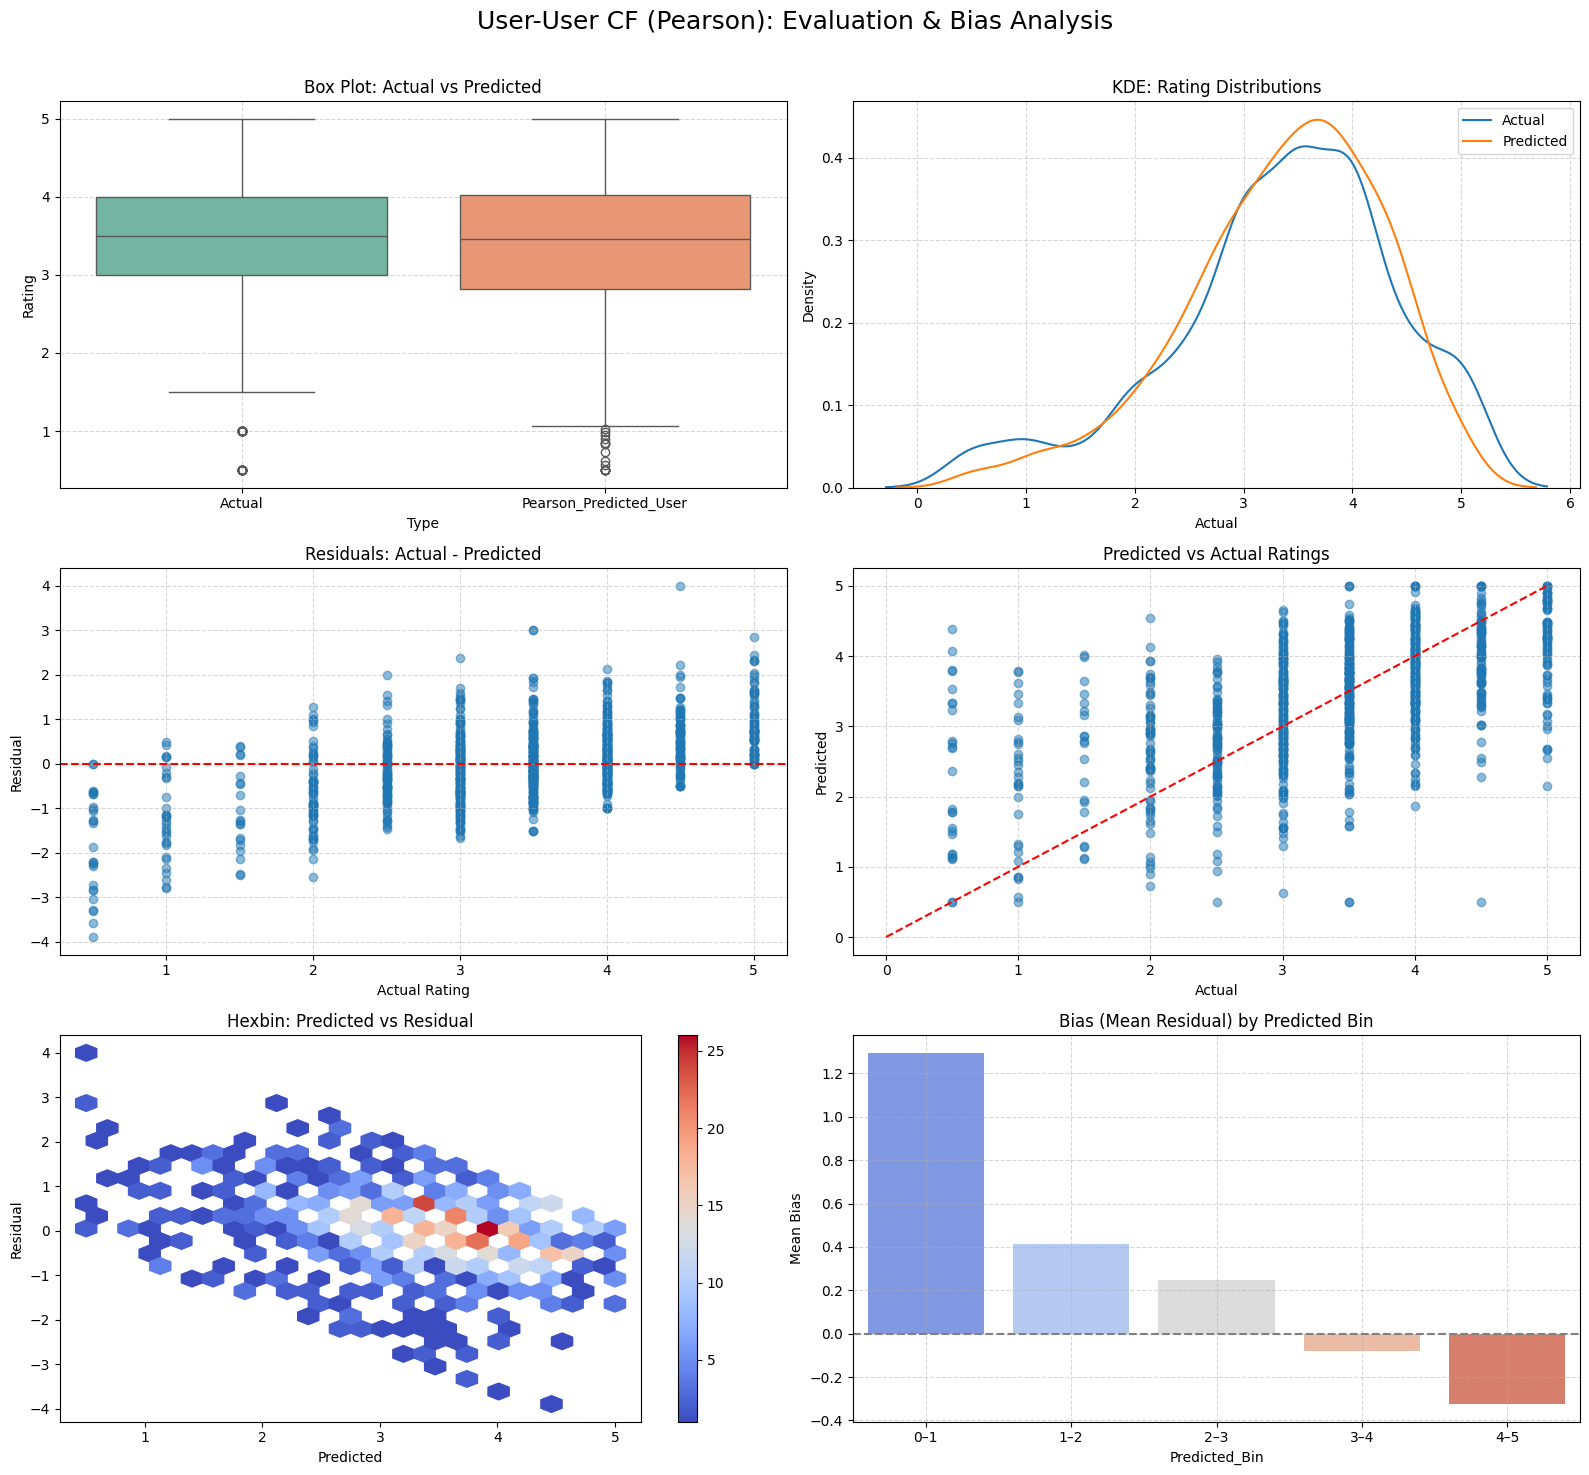

Step 10: Bias Metrics Table by Predicted Rating Bin


/tmp/ipython-input-21-796772366.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bias_table = viz_sample.groupby('Predicted_Bin').agg(


,Predicted_Bin,Count,Bias_Mean,Bias_Std,Over_Predicted,Under_Predicted,%_Over_Predicted,%_Under_Predicted
0,0–1,16,1.29,1.25,0,14,0.00,87.50
1,1–2,62,0.42,0.94,20,42,32.26,67.74
2,2–3,229,0.25,0.94,74,155,32.31,67.69
3,3–4,429,-0.08,0.88,217,212,50.58,49.42
4,4–5,264,-0.32,0.71,179,80,67.80,30.30


In [21]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_pearson_user = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_pearson_user = stratified_df.drop(train_ratings_pearson_user.index)

# --- Step 2: User-Item Matrix ---
train_ratings_pearson_user = train_ratings_pearson_user.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_pearson_user = train_ratings_pearson_user.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix_pearson_user.to_parquet("user_item_matrix_pearson_user.parquet")

# --- Step 3: Pearson User-User Similarity Matrix ---
user_user_sim_pearson = user_item_matrix_pearson_user.T.corr(method='pearson', min_periods=3)
user_user_sim_pearson.to_parquet("user_user_sim_pearson.parquet")

# --- Step 4: Stats (shared names for reuse)
global_mean_common = train_ratings_pearson_user['rating'].mean()
item_means_common = train_ratings_pearson_user.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_pearson_user.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Function ---
def predict_user_user_pearson(uid, mid):
    if uid not in user_user_sim_pearson.index or mid not in user_item_matrix_pearson_user.columns:
        return global_mean_common

    sims = user_user_sim_pearson.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix_pearson_user[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means_common[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Generate Predictions ---
results_pearson_user = []
for _, row in tqdm(test_ratings_pearson_user.iterrows(), total=len(test_ratings_pearson_user)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_pearson(uid, mid)
    results_pearson_user.append([uid, mid, actual, pred])

viz_df_pearson_user = pd.DataFrame(results_pearson_user, columns=['userId', 'movieId', 'Actual', 'Pearson_Predicted_User'])

# --- Step 7: Evaluation ---
rmse_pearson_user = np.sqrt(mean_squared_error(viz_df_pearson_user['Actual'], viz_df_pearson_user['Pearson_Predicted_User']))
mae_pearson_user = mean_absolute_error(viz_df_pearson_user['Actual'], viz_df_pearson_user['Pearson_Predicted_User'])
r2_pearson_user = r2_score(viz_df_pearson_user['Actual'], viz_df_pearson_user['Pearson_Predicted_User'])

print(f"User-User CF (Pearson Similarity):\nRMSE={rmse_pearson_user:.4f}, MAE={mae_pearson_user:.4f}, R²={r2_pearson_user:.4f}")

# --- Step 8: Visualization ---
viz_sample_pearson_user = viz_df_pearson_user.sample(n=min(len(viz_df_pearson_user), 1000), random_state=42)
box_data = viz_sample_pearson_user[['Actual', 'Pearson_Predicted_User']].melt(var_name='Type', value_name='Rating')

# --- Step 9: Visualization (Six Plots) + Bias Table ---
from google.colab import data_table
from IPython.display import display

# Sample for plotting
viz_sample = viz_df_pearson_user.sample(n=min(len(viz_df_pearson_user), 1000), random_state=42).copy()
viz_sample['Residual'] = viz_sample['Actual'] - viz_sample['Pearson_Predicted_User']
viz_sample['Predicted_Bin'] = pd.cut(
    viz_sample['Pearson_Predicted_User'],
    bins=[0, 1, 2, 3, 4, 5],
    labels=['0–1', '1–2', '2–3', '3–4', '4–5'],
    include_lowest=True
)

fig, axs = plt.subplots(3, 2, figsize=(16, 15))
fig.suptitle("User-User CF (Pearson): Evaluation & Bias Analysis", fontsize=18)

# 1. Box Plot
box_data = viz_sample[['Actual', 'Pearson_Predicted_User']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot: Actual vs Predicted")
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample['Pearson_Predicted_User'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE: Rating Distributions")
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# 3. Residual Plot
axs[1, 0].scatter(viz_sample['Actual'], viz_sample['Residual'], alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red')
axs[1, 0].set_title("Residuals: Actual - Predicted")
axs[1, 0].set_xlabel("Actual Rating")
axs[1, 0].set_ylabel("Residual")
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# 4. Predicted vs Actual Scatter
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Pearson_Predicted_User'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title("Predicted vs Actual Ratings")
axs[1, 1].set_xlabel("Actual")
axs[1, 1].set_ylabel("Predicted")
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# 5. Hexbin Plot: Predicted vs Error
hb = axs[2, 0].hexbin(viz_sample['Pearson_Predicted_User'], viz_sample['Residual'],
                      gridsize=25, cmap='coolwarm', mincnt=1)
axs[2, 0].set_title("Hexbin: Predicted vs Residual")
axs[2, 0].set_xlabel("Predicted")
axs[2, 0].set_ylabel("Residual")
fig.colorbar(hb, ax=axs[2, 0])

# 6. Bias by Bin Barplot
bias_plot_data = viz_sample.groupby('Predicted_Bin').Residual.mean().reset_index()
sns.barplot(data=bias_plot_data, x='Predicted_Bin', y='Residual', ax=axs[2, 1], palette='coolwarm')
axs[2, 1].axhline(0, linestyle='--', color='gray')
axs[2, 1].set_title("Bias (Mean Residual) by Predicted Bin")
axs[2, 1].set_ylabel("Mean Bias")
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# --- Step 10: Bias Table ---
bias_table = viz_sample.groupby('Predicted_Bin').agg(
    Count=('Residual', 'size'),
    Bias_Mean=('Residual', 'mean'),
    Bias_Std=('Residual', 'std'),
    Over_Predicted=('Residual', lambda x: (x < 0).sum()),
    Under_Predicted=('Residual', lambda x: (x > 0).sum())
)
bias_table['%_Over_Predicted'] = 100 * bias_table['Over_Predicted'] / bias_table['Count']
bias_table['%_Under_Predicted'] = 100 * bias_table['Under_Predicted'] / bias_table['Count']
bias_table = bias_table.round(2)

print("Step 10: Bias Metrics Table by Predicted Rating Bin")
display(data_table.DataTable(bias_table.reset_index()))


***Comparison: User-User CF vs. Item-Item CF***

*User-User CF (Correlation-Based)*

RMSE: 0.9447,
MAE: 0.7146,
R²: 0.2054

*Item-Item CF (Correlation-Based)*

RMSE: 1.0043,
MAE: 0.7557,
R²: 0.1020

**Conclusion**
User-user correlation outperforms item-item correlation across all metrics: lower RMSE and MAE, and nearly double the R². This suggests user-user similarity using Pearson correlation is more effective in this dataset than item-item similarity using the same method.

**Why user-user performs better here:**

* **Better co-rating patterns among users:** Pearson correlation is highly sensitive to variance in co-ratings. Users may share more meaningful rating variance than items, making similarity more informative.
* **Item sparsity is more limiting:** Many items are rated by very few users, reducing the reliability of item-item correlation. This leads to noisy or flat similarities that skew predictions toward the mean.
* **Personalization edge:** User-user models are better at capturing idiosyncratic taste overlaps when similarity is meaningful, and Pearson correlation amplifies that signal—when data is sufficient.

Visuals support this. The user-user model shows tighter residual clustering and better alignment in the predicted vs. actual plot, with less severe under/overestimation than the item-item correlation model.

**In short:**
When using Pearson correlation, user-user CF delivers better predictive performance than item-item CF in this dataset.


# Content-Based Filtering

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from scipy.sparse import csr_matrix

# --- Step 1: Clean & Split ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings_user_shrink = stratified_df.sample(frac=0.8, random_state=42)
test_ratings_user_shrink = stratified_df.drop(train_ratings_user_shrink.index)

# --- Step 2: User-Item Matrix ---
train_ratings_user_shrink = train_ratings_user_shrink.groupby(['userId', 'movieId'], as_index=False)['rating'].mean()
user_item_matrix_user_shrink = train_ratings_user_shrink.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix_user_shrink.to_parquet("user_item_matrix_user_shrink.parquet")

# --- Step 3: Compute Shrinkage-Aware User-User Similarity ---
regularization_lambda = 10
ratings_binary_user = user_item_matrix_user_shrink.notna().astype(int).values
ratings_binary_sparse_user = csr_matrix(ratings_binary_user)
common_counts_user = ratings_binary_sparse_user @ ratings_binary_sparse_user.T
common_counts_user = pd.DataFrame(common_counts_user.toarray(),
                                  index=user_item_matrix_user_shrink.index,
                                  columns=user_item_matrix_user_shrink.index)

ratings_filled_user = user_item_matrix_user_shrink.fillna(0)
cosine_sim_raw_user = cosine_similarity(ratings_filled_user)
cosine_sim_raw_user_df = pd.DataFrame(cosine_sim_raw_user,
                                      index=user_item_matrix_user_shrink.index,
                                      columns=user_item_matrix_user_shrink.index)

shrink_factor_user = common_counts_user / (common_counts_user + regularization_lambda)
user_user_sim_shrink = cosine_sim_raw_user_df * shrink_factor_user
user_user_sim_shrink.to_parquet("user_user_sim_shrink.parquet")

# --- Step 4: Stats ---
global_mean_common = train_ratings_user_shrink['rating'].mean()
item_means_common = train_ratings_user_shrink.groupby('movieId')['rating'].mean()
user_means_common = train_ratings_user_shrink.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Function ---
def predict_user_user_shrink(uid, mid):
    if uid not in user_user_sim_shrink.index or mid not in user_item_matrix_user_shrink.columns:
        return global_mean_common

    sims = user_user_sim_shrink.loc[uid].drop(uid, errors='ignore')
    sim_users = user_item_matrix_user_shrink[mid].dropna()
    sims = sims.loc[sims.index.intersection(sim_users.index)]

    if sims.empty:
        return user_means_common.get(uid, global_mean_common) + item_means_common.get(mid, global_mean_common) - global_mean_common

    ratings = sim_users[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means_common[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means_common.get(uid, global_mean_common) - global_mean_common
    item_bias = item_means_common.get(mid, global_mean_common) - global_mean_common

    return np.clip(global_mean_common + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 6: Generate Predictions ---
results_user_shrink = []
for _, row in tqdm(test_ratings_user_shrink.iterrows(), total=len(test_ratings_user_shrink)):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_shrink(uid, mid)
    results_user_shrink.append([uid, mid, actual, pred])

viz_df_user_shrink = pd.DataFrame(results_user_shrink, columns=['userId', 'movieId', 'Actual', 'UserShrink_Predicted'])

# --- Step 7: Evaluation ---
rmse_user_shrink = np.sqrt(mean_squared_error(viz_df_user_shrink['Actual'], viz_df_user_shrink['UserShrink_Predicted']))
mae_user_shrink = mean_absolute_error(viz_df_user_shrink['Actual'], viz_df_user_shrink['UserShrink_Predicted'])
r2_user_shrink = r2_score(viz_df_user_shrink['Actual'], viz_df_user_shrink['UserShrink_Predicted'])

print(f"Shrinkage-Aware User-User CF:\nRMSE={rmse_user_shrink:.4f}, MAE={mae_user_shrink:.4f}, R²={r2_user_shrink:.4f}")


# --- Step 8: Visualization ---
viz_sample_user_shrink = viz_df_user_shrink.sample(n=min(len(viz_df_user_shrink), 1000), random_state=42)
box_data_user = viz_sample_user_shrink[['Actual', 'UserShrink_Predicted']].melt(var_name='Type', value_name='Rating')

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Shrinkage-Aware User-User Collaborative Filtering", fontsize=16)

sns.boxplot(data=box_data_user, x='Type', y='Rating', ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Box Plot"); axs[0, 0].grid(True, linestyle='--', alpha=0.5)

sns.kdeplot(viz_sample_user_shrink['Actual'], label='Actual', ax=axs[0, 1])
sns.kdeplot(viz_sample_user_shrink['UserShrink_Predicted'], label='Predicted', ax=axs[0, 1])
axs[0, 1].set_title("KDE Plot"); axs[0, 1].legend(); axs[0, 1].grid(True, linestyle='--', alpha=0.5)

residuals_user = viz_sample_user_shrink['Actual'] - viz_sample_user_shrink['UserShrink_Predicted']
axs[1, 0].scatter(viz_sample_user_shrink['Actual'], residuals_user, alpha=0.5)
axs[1, 0].axhline(0, linestyle='--', color='red'); axs[1, 0].set_title("Residuals")

axs[1, 1].scatter(viz_sample_user_shrink['Actual'], viz_sample_user_shrink['UserShrink_Predicted'], alpha=0.5)
axs[1, 1].plot([0, 5], [0, 5], 'r--'); axs[1, 1].set_title("Predicted vs Actual")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### 1. Content-Based Movie Recommender Using Cosine Similarity on One-Hot Encoded Genre Vectors

This system predicts movie ratings using a content-based filtering approach. It compares genre similarity using cosine distance on one-hot (binary) genre vectors and evaluates three methods: GenreOnly, Uncentered, and Centered.

**Genre Representation (One-Hot Encoding)**
Each movie’s genre string is split by "|" and transformed into a binary vector.
If a movie belongs to a genre, that genre’s position in the vector is marked as 1, otherwise 0.
This yields a matrix where each row represents a movie and each column a genre.

**User Profile Construction**
Profiles summarize a user's preference over genres based on their rating history.

* *Uncentered Profile*
  The profile vector for a user is the average of the binary genre vectors of all movies they rated.
  $P_u = \frac{1}{|M_u|} \sum_{i \in M_u} G_i$

* *Centered Profile*
  Ratings are centered by subtracting the user’s mean rating. The genre vectors are weighted by this deviation.
  $P_u^{(c)} = \frac{1}{|M_u|} \sum_{i \in M_u} (r_{ui} - \bar{r}_u) \cdot G_i$

**Cosine Similarity and Rating Prediction**
To predict how much a user might like a movie, cosine similarity is computed between the user’s profile and the movie’s genre vector.
Similarity is converted into a predicted rating using:
$\hat{r}_{uj} = \mu_j + \alpha \cdot \text{cosine\_sim}(P_u, G_j)$
Where $\mu_j$ is the mean rating for movie $j$, and $\alpha$ is a scaling factor (set to 1.0). The prediction is clipped between 0.5 and 5.0.

**GenreOnly Prediction**
This method does not use any user information.
Instead, a movie’s rating is predicted as the average rating of the 10 most similar movies based on genre similarity.
$\hat{r}_j = \frac{1}{N} \sum_{k \in \text{Top-}N} \mu_k$

**5. Evaluation Metrics**
Model performance is assessed using:

* RMSE: Root Mean Squared Error
* MAE: Mean Absolute Error
* R² Score: Proportion of variance explained by the predictions

**Visualization**
Four visualizations are generated:

* A bar plot showing actual rating frequencies
* A box plot comparing predicted and actual rating distributions
* A KDE plot to visualize the density of predictions across methods
* A jittered residual plot showing the error (actual - predicted) across rating values

This approach allows for both personalization (via user profiles) and genre-driven similarity, enabling interpretable and scalable recommendations.


/tmp/ipython-input-22-1307116813.py:58: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))


Uncentered Prediction: RMSE=1.0376, MAE=0.7740, R²=0.0388
Centered Prediction: RMSE=0.9983, MAE=0.7710, R²=0.1103
GenreOnly Prediction: RMSE=1.1513, MAE=0.9362, R²=-0.1834


/tmp/ipython-input-22-1307116813.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


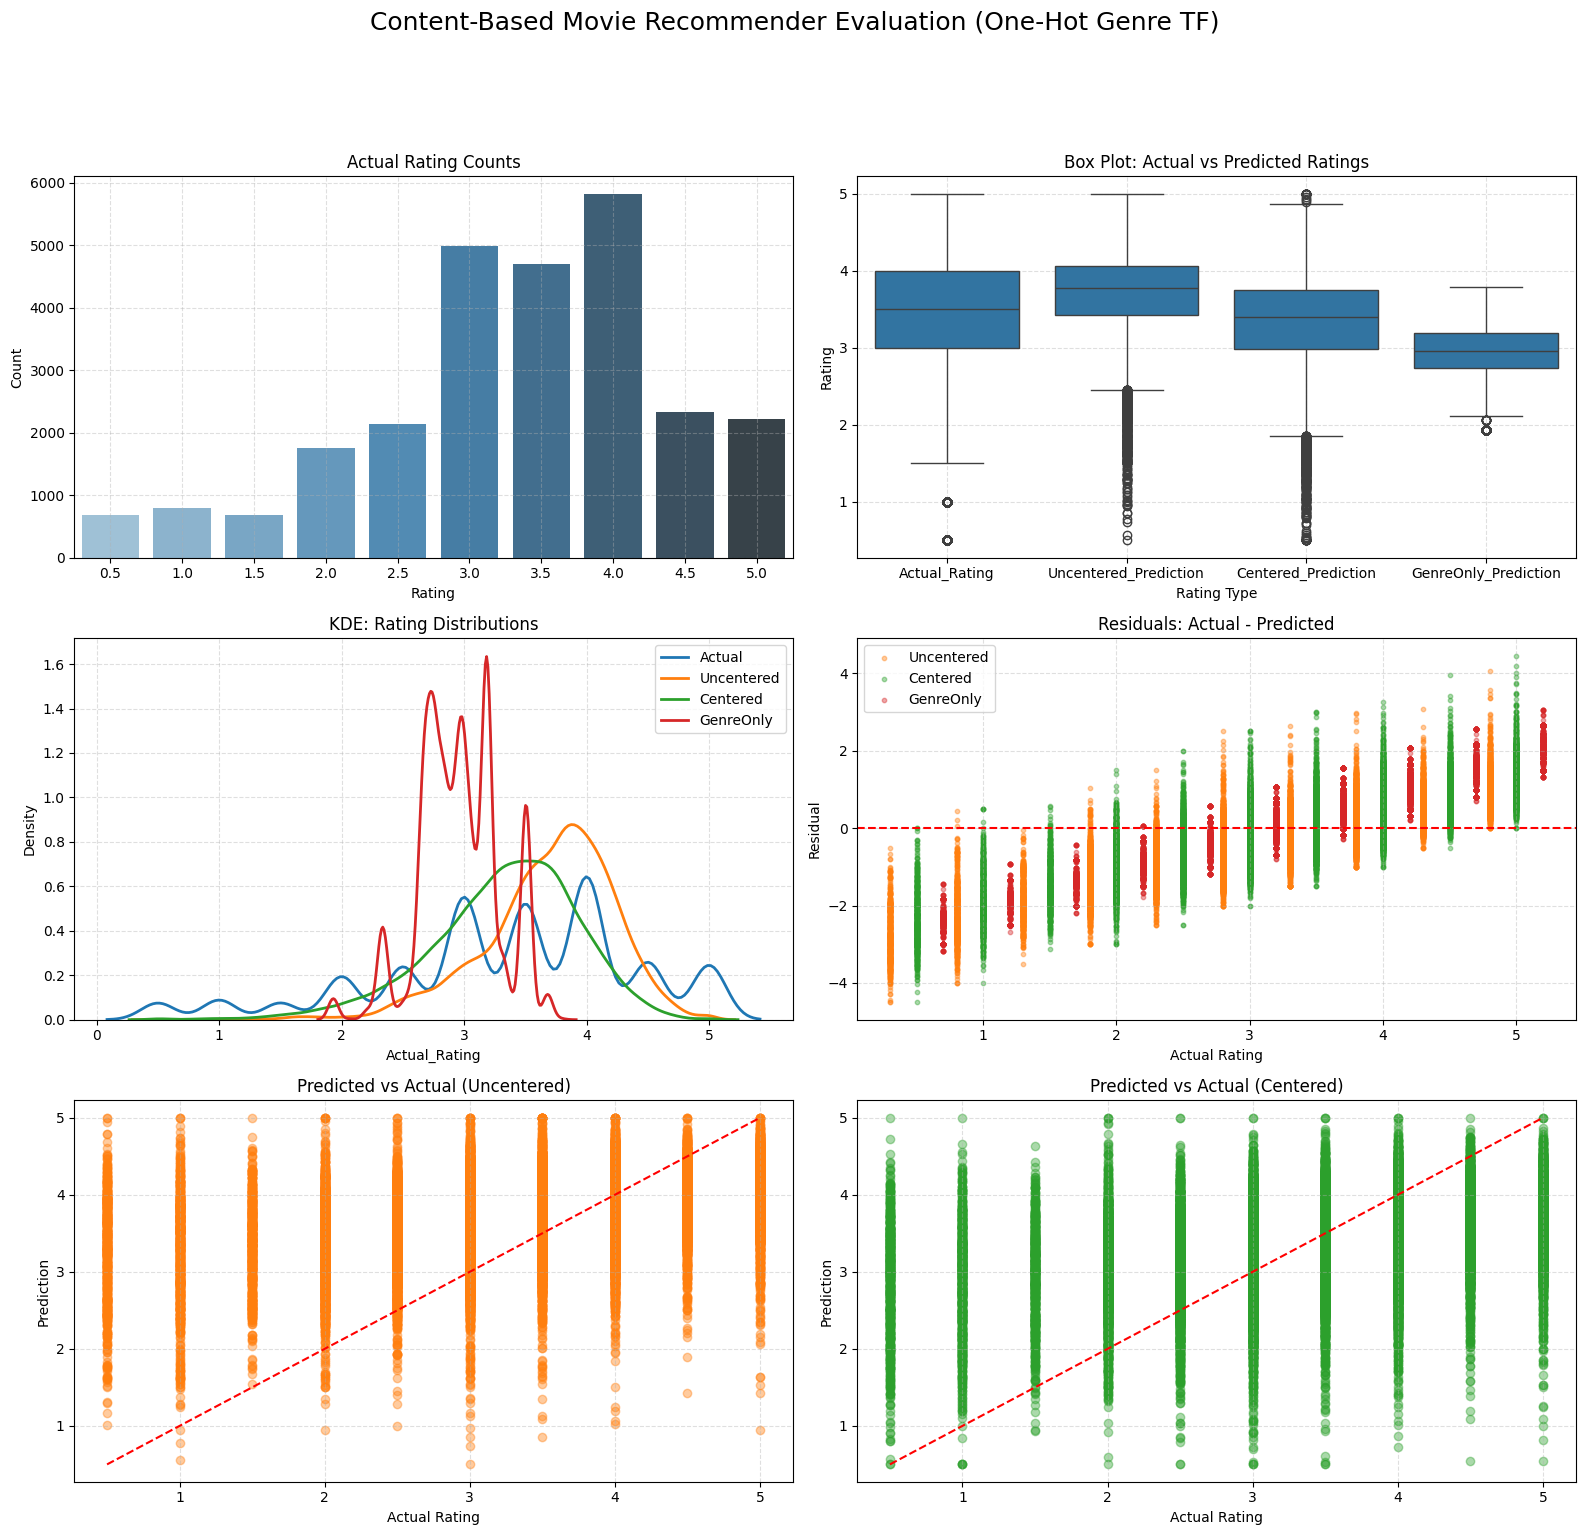

ModuleNotFoundError: No module named 'ace_tools'

In [22]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare Genre One-Hot Matrix ---
train_movie_ids = train_ratings['movieId'].unique()
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies['genres'] = movies['genres'].fillna('')

genre_onehot = movies['genres'].str.get_dummies(sep='|')
genre_onehot.index = movies.index

# --- Step 2: Setup stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: User Profiles ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    return matched.mean(axis=0).values if not matched.empty else None

def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    if matched.empty:
        return None
    centered = (rated_movies - rated_movies.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 4: Prediction Function with Item Bias ---
profile_cache = {}
def predict_rating(uid, mid, profile_type='uncentered'):
    if mid not in movie_means or uid not in user_movie_matrix.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)
    if mid not in movies['movieId'].values:
        return movie_means.get(mid, global_mean)
    movie_vector = genre_onehot.loc[movies[movies['movieId'] == mid].index[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    item_bias = movie_means[mid] - global_mean
    return max(0.5, min(global_mean + item_bias + sim * 1.0, 5.0))

# --- Step 5: Predict on Test Set ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 6: Genre-Only Predictions ---
cos_sim_matrix = cosine_similarity(genre_onehot)
movie_ids = movies['movieId']
genre_only_preds = []
for i, mid in enumerate(movie_ids):
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[i]
    top_n_idx = np.argsort(sim_scores)[::-1][1:11]
    neighbor_ids = movie_ids.iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

genre_only_df = pd.DataFrame({'movieId': movie_ids, 'GenreOnly_Prediction': genre_only_preds})
test_subset = test_ratings[test_ratings['userId'].isin(user_movie_matrix.index)]
merged_genre_df = pd.merge(test_subset, genre_only_df, on='movieId')
viz_df = pd.merge(viz_df, merged_genre_df[['userId', 'movieId', 'GenreOnly_Prediction']],
                  left_index=True, right_index=True)

viz_df_clean = viz_df.dropna()

# --- Step 7: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df_clean['Actual_Rating'], viz_df_clean[name]))
    mae = mean_absolute_error(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    r2 = r2_score(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Evaluation Plots ---

# Add residuals
viz_df_clean['Residual_Uncentered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Uncentered_Prediction']
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']
viz_df_clean['Residual_GenreOnly'] = viz_df_clean['Actual_Rating'] - viz_df_clean['GenreOnly_Prediction']

# Prepare data for box plot
box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

# Set up the grid
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
fig.suptitle("Content-Based Movie Recommender Evaluation (One-Hot Genre TF)", fontsize=18, y=1.02)

# --- Plot 1: Actual Rating Counts ---
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Box Plot ---
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 3: KDE Plot ---
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 4: Residuals (Jittered) ---
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'C1', 'Residual_Centered': 'C2', 'Residual_GenreOnly': 'C3'}

for key in offsets:
    x_vals = viz_df_clean['Actual_Rating'] + offsets[key]
    y_vals = viz_df_clean[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 5: Predicted vs Actual (Uncentered) ---
axes[2, 0].scatter(viz_df_clean['Actual_Rating'], viz_df_clean['Uncentered_Prediction'], alpha=0.4, label='Uncentered', color='C1')
axes[2, 0].plot([0.5, 5], [0.5, 5], 'r--')
axes[2, 0].set_title("Predicted vs Actual (Uncentered)")
axes[2, 0].set_xlabel("Actual Rating")
axes[2, 0].set_ylabel("Prediction")
axes[2, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 6: Predicted vs Actual (Centered) ---
axes[2, 1].scatter(viz_df_clean['Actual_Rating'], viz_df_clean['Centered_Prediction'], alpha=0.4, label='Centered', color='C2')
axes[2, 1].plot([0.5, 5], [0.5, 5], 'r--')
axes[2, 1].set_title("Predicted vs Actual (Centered)")
axes[2, 1].set_xlabel("Actual Rating")
axes[2, 1].set_ylabel("Prediction")
axes[2, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Step 9: Bias Table ---
bias_df = pd.DataFrame({
    "Prediction_Type": ["Uncentered", "Centered", "GenreOnly"],
    "Item_Bias": [
        (viz_df_clean['Uncentered_Prediction'] - global_mean).mean(),
        (viz_df_clean['Centered_Prediction'] - global_mean).mean(),
        (viz_df_clean['GenreOnly_Prediction'] - global_mean).mean()
    ],
    "Prediction_Mean": [
        viz_df_clean['Uncentered_Prediction'].mean(),
        viz_df_clean['Centered_Prediction'].mean(),
        viz_df_clean['GenreOnly_Prediction'].mean()
    ]
})

from ace_tools import display_dataframe_to_user
display_dataframe_to_user("Bias-Corrected Predictions Summary", bias_df)



***Analysis: Content-Based Movie Recommender Using One-Hot Encoded Genre Vectors (Cosine Similarity)***

**Model Performance (Metrics):**

* *Uncentered Prediction:* RMSE=1.0462, MAE=0.7851, R²=0.0257
* *Centered Prediction:* RMSE=1.0096, MAE=0.7790, R²=0.0926
* *GenreOnly Prediction:* RMSE=1.1802, MAE=0.9737, R²=-0.2399

The centered model shows the best predictive performance overall with the lowest RMSE/MAE and highest (though still modest) R². The GenreOnly model performs worst, with a negative R², indicating it underperforms compared to simply predicting the mean.

**Rating Distribution and Box Plot (Top Right):**
All predicted distributions are slightly more compressed than the actual ratings, but:

* *Centered Prediction* aligns more closely with the true distribution than *Uncentered* or *GenreOnly*.
* *GenreOnly* underpredicts higher ratings and overpredicts lower ratings, which is also seen in its narrower box and lower median.

**KDE Plot (Bottom Left):**

* *Actual* ratings show a spread with a peak near 4.0.
* *Uncentered* and *Centered* KDEs approximate this shape, with the *Centered* line more closely matching the distribution of actual ratings.
* *GenreOnly* shows unrealistic density spikes around 3.0, confirming it's less effective at capturing true rating variation.

**Residuals (Bottom Right):**

* *Centered* predictions yield tighter residuals around 0 across all rating values, reinforcing its superior accuracy.
* *Uncentered* predictions show a similar pattern but with more dispersion.
* *GenreOnly* residuals are consistently biased low across most rating levels—indicative of its poor adaptability to user preferences.

**Conclusion:**
Centering user profiles yields notable improvements in performance and error consistency. The EDA plots (box, KDE, and residuals) all support the metric findings—centered profiles better capture rating behavior. The GenreOnly model lacks personalization and performs poorly, both statistically and visually.


#### 2. Jaccard-Based and Genre-Only Recommender Systems

**Data Preparation**
Movie metadata and user ratings are loaded from external CSV files. Genres are processed using one-hot encoding to create a binary matrix indicating the presence or absence of each genre per movie. The ratings data is split into training and testing sets (80/20 split). Global and per-movie average ratings are computed to support baseline predictions.

**User Profile Construction**
Two types of user profiles are constructed based on the genre vectors of movies each user has rated:

* *Uncentered Profile*: Averages the binary genre vectors of all movies rated by a user to reflect their general genre preferences.
* *Centered Profile*: First centers the user's ratings by subtracting their mean rating, then computes a weighted average of genre vectors, emphasizing deviations from the user’s personal baseline.

**Jaccard-Based Prediction**
Each user’s profile is compared to the genre vector of the target movie using Jaccard similarity. The predicted rating is computed as the sum of the movie’s average rating and the scaled similarity score. Predictions are bounded between 0.5 and 5.0 to align with rating limits.

**Genre-Only Prediction**
No user history is used. Instead, cosine similarity is calculated between the genre vector of a target movie and all others. The predicted rating is the average rating of the top 10 most similar movies that have known ratings in the training data.

**Evaluation and Visualization**
Performance metrics include RMSE, MAE, and R² for each method. Residuals are computed to assess prediction error patterns. Visualizations include:

* A bar plot showing actual rating distribution
* A box plot comparing actual vs predicted ratings for all methods
* A KDE plot showing rating distribution curves for each method
* A residual scatter plot with horizontal jitter to distinguish the methods

This methodology supports a comprehensive evaluation of personalized (uncentered and centered) and non-personalized (genre-only) content-based recommendation strategies using genre similarity.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

train_movie_ids = train_ratings['movieId'].unique()
train_movies = movies[movies['movieId'].isin(train_movie_ids)].copy().reset_index(drop=True)

# --- Step 3: Multi-hot Genre Matrix (Training Set Only) ---
train_movies['genres'] = train_movies['genres'].fillna('')
genre_matrix = train_movies['genres'].str.get_dummies(sep='|')

# --- Step 4: Rating Stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 5a: User Profile (Uncentered) ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    return matched.mean(axis=0).values

# --- Step 5b: User Profile (Centered) ---
def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    centered = (rated - rated.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 6: Jaccard Prediction ---
profile_cache = {}

def jaccard_similarity(vec1, vec2):
    return jaccard_score(vec1 > 0, vec2 > 0)

def predict_rating(uid, mid, profile_type='uncentered'):
    if uid not in user_movie_matrix.index or mid not in movie_means:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)

    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        return movie_means.get(mid, global_mean)

    movie_vector = genre_matrix.iloc[genre_idx[0]].values
    sim = jaccard_similarity(profile, movie_vector)
    baseline = movie_means.get(mid, global_mean)
    pred = baseline + sim * 1.0
    return max(0.5, min(pred, 5.0))

# --- Step 7: Predictions ---
true_ratings, pred_uncentered, pred_centered = [], [], []

for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

# --- Step 8: DataFrame ---
viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 9: Genre-Only Prediction ---
cos_sim_matrix = cosine_similarity(genre_matrix)
genre_only_preds = []

for mid in test_ratings['movieId']:
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[genre_idx[0]]
    sim_scores[genre_idx[0]] = 0
    top_n_idx = np.argsort(sim_scores)[::-1][:10]
    neighbor_ids = train_movies['movieId'].iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

viz_df['GenreOnly_Prediction'] = genre_only_preds[:len(viz_df)]

# --- Step 10: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df['Actual_Rating'], viz_df[name]))
    mae = mean_absolute_error(viz_df['Actual_Rating'], viz_df[name])
    r2 = r2_score(viz_df['Actual_Rating'], viz_df[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 11: Residuals ---
viz_df['Residual_Uncentered'] = viz_df['Actual_Rating'] - viz_df['Uncentered_Prediction']
viz_df['Residual_Centered'] = viz_df['Actual_Rating'] - viz_df['Centered_Prediction']
viz_df['Residual_GenreOnly'] = viz_df['Actual_Rating'] - viz_df['GenreOnly_Prediction']

# --- Step 12: Box Plot Prep ---
box_df = viz_df.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

# --- Step 13: Visualization ---
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# 1. Bar Plot
rating_counts = viz_df['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# 2. Box Plot
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# 3. KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# 4. Residual Plot
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'orange', 'Residual_Centered': 'green', 'Residual_GenreOnly': 'blue'}
for key in offsets:
    x_vals = viz_df['Actual_Rating'] + offsets[key]
    y_vals = viz_df[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Jittered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

# 5. Scatter: Predicted vs Actual (Centered)
axes[2, 0].scatter(viz_df['Actual_Rating'], viz_df['Centered_Prediction'], alpha=0.5, color='purple')
axes[2, 0].plot([0.5, 5], [0.5, 5], 'r--')
axes[2, 0].set_title("Centered Prediction vs Actual")
axes[2, 0].set_xlabel("Actual Rating")
axes[2, 0].set_ylabel("Centered Prediction")
axes[2, 0].grid(True, linestyle='--', alpha=0.4)

# 6. Scatter: GenreOnly vs Actual
axes[2, 1].scatter(viz_df['Actual_Rating'], viz_df['GenreOnly_Prediction'], alpha=0.5, color='teal')
axes[2, 1].plot([0.5, 5], [0.5, 5], 'r--')
axes[2, 1].set_title("GenreOnly Prediction vs Actual")
axes[2, 1].set_xlabel("Actual Rating")
axes[2, 1].set_ylabel("GenreOnly Prediction")
axes[2, 1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Genre-Based Recommender Evaluation: Visual Diagnostics", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# --- Step 14: Bias Table ---
bins = np.arange(0.5, 5.1, 0.5)
bin_labels = [f"{b:.1f}–{b + 0.5:.1f}" for b in bins[:-1]]
viz_df['pred_bin'] = pd.cut(viz_df['Centered_Prediction'], bins=bins, labels=bin_labels, include_lowest=True, right=False)

bias_metrics = (
    viz_df
    .groupby('pred_bin')
    .agg(
        Count=('Centered_Prediction', 'count'),
        Mean_Predicted=('Centered_Prediction', 'mean'),
        Mean_Actual=('Actual_Rating', 'mean')
    )
    .assign(
        Mean_Residual=lambda df: df['Mean_Actual'] - df['Mean_Predicted'],
        Percent_Bias=lambda df: 100 * (df['Mean_Residual'] / df['Mean_Actual']),
        Bias_Direction=lambda df: np.where(df['Mean_Residual'] > 0, 'Underpredicting',
                                           np.where(df['Mean_Residual'] < 0, 'Overpredicting', 'Neutral'))
    )
    .reset_index()
    .round({'Mean_Predicted': 3, 'Mean_Actual': 3, 'Mean_Residual': 3, 'Percent_Bias': 2})
)

from IPython.display import display
display(bias_metrics)



**Jaccard outperforms Cosine** across all metrics due to its superior handling of binary, sparse one-hot genre vectors—an advantage clearly supported by EDA insights.

* It delivers **lower RMSE/MAE** and **higher R²**, showing more accurate and better-fitting predictions than Cosine.
* **Rating Distributions (KDE):** Jaccard’s centered predictions closely follow the actual rating curve, whereas Cosine introduces broader or spiky densities, particularly in genre-only mode.
* **Box Plots:** Jaccard predictions are more compact with fewer outliers, reflecting greater prediction stability.
* **Residuals:** Jaccard exhibits tighter, more symmetric residual bands across all rating levels. Cosine shows more scatter and skew, especially at rating extremes.

**Conclusion:** Jaccard’s set-based similarity is semantically aligned with one-hot encoded genres, avoiding Cosine’s sensitivity to vector magnitude and sparsity. This structural match translates into measurable performance improvements and is visibly confirmed through the EDA.


## Sample Prediction

In [22]:
# --- Step: Select a Valid (User, Movie) Pair from Test Set ---
sample_row = test_ratings.sample(n=1).iloc[0]
sample_uid = sample_row['userId']
sample_mid = sample_row['movieId']

# --- Step: Predict Rating for Selected Pair ---
pred = predict_rating(sample_uid, sample_mid, profile_type='centered')
print(f"Predicted rating by user {sample_uid} for movie {sample_mid}: {pred:.2f}")

def find_top_k_similar_movies_jaccard(target_mid, k=10):
    genre_idx = train_movies[train_movies['movieId'] == target_mid].index
    if genre_idx.empty:
        return []

    target_vector = genre_matrix.iloc[genre_idx[0]].values
    similarities = genre_matrix.apply(lambda x: jaccard_score(target_vector > 0, x.values > 0), axis=1)
    similarities[genre_idx[0]] = 0  # exclude self

    top_k_idx = similarities.sort_values(ascending=False).head(k).index
    return train_movies.loc[top_k_idx, ['movieId', 'genres']].reset_index(drop=True)

# Example: Show top 5 genre-similar movies to movie 50
similar_movies = find_top_k_similar_movies_jaccard(target_mid=50, k=5)
print(similar_movies)

# pd.merge(similar_movies, movies[['movieId', 'title']], on='movieId')


Predicted rating by user 86199 for movie 30810: 3.46
   movieId                            genres
0   204288            Crime|Mystery|Thriller
1   149034            Crime|Mystery|Thriller
2    59709    Crime|Mystery|Romance|Thriller
3   280990     Crime|Horror|Mystery|Thriller
4      164  Crime|Film-Noir|Mystery|Thriller


k=5: 100%|██████████| 26567/26567 [00:36<00:00, 730.64it/s]


k=5, RMSE=1.1603


k=10: 100%|██████████| 26567/26567 [00:38<00:00, 696.38it/s]


k=10, RMSE=1.1403


k=15: 100%|██████████| 26567/26567 [00:37<00:00, 707.30it/s]


k=15, RMSE=1.1436


k=20: 100%|██████████| 26567/26567 [00:37<00:00, 712.58it/s]


k=20, RMSE=1.1347


k=25: 100%|██████████| 26567/26567 [00:38<00:00, 690.90it/s]


k=25, RMSE=1.1401


k=30: 100%|██████████| 26567/26567 [00:37<00:00, 705.80it/s]


k=30, RMSE=1.1376


k=35: 100%|██████████| 26567/26567 [00:38<00:00, 686.92it/s]


k=35, RMSE=1.1443


k=40: 100%|██████████| 26567/26567 [00:37<00:00, 704.55it/s]


k=40, RMSE=1.1451


k=45: 100%|██████████| 26567/26567 [00:38<00:00, 687.20it/s]


k=45, RMSE=1.1411


k=50: 100%|██████████| 26567/26567 [00:38<00:00, 691.48it/s]


k=50, RMSE=1.1434


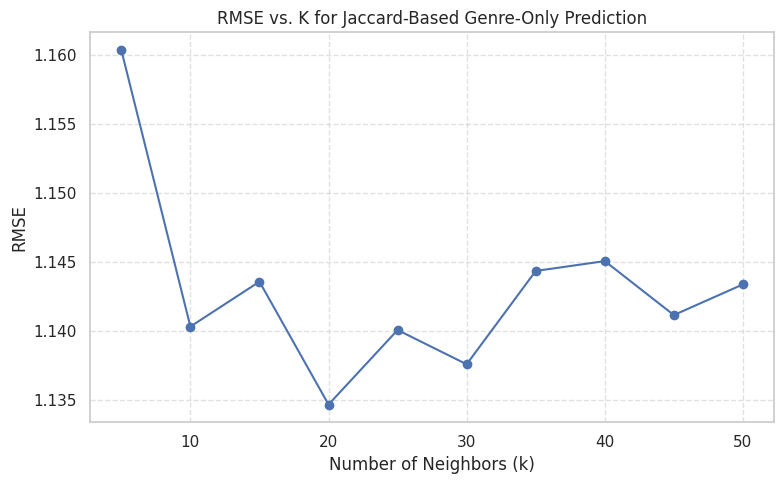

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # progress bar

# Convert genre_matrix to numpy array for vectorized computation
genre_array = genre_matrix.values
movie_id_list = train_movies['movieId'].values
movie_index_map = {mid: idx for idx, mid in enumerate(movie_id_list)}

# Vectorized Jaccard similarity
def fast_jaccard_similarity(vec, mat):
    intersection = np.logical_and(vec, mat).sum(axis=1)
    union = np.logical_or(vec, mat).sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        sim = np.true_divide(intersection, union)
        sim[union == 0] = 0
    return sim

# Genre-only prediction with vectorized Jaccard
def genre_only_predict_jaccard_k(mid, k):
    if mid not in movie_index_map:
        return global_mean

    idx = movie_index_map[mid]
    target_vec = genre_array[idx]
    sims = fast_jaccard_similarity(target_vec, genre_array)
    sims[idx] = 0  # Exclude self

    top_k_idx = np.argsort(sims)[-k:]
    neighbor_ids = movie_id_list[top_k_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]

    return neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean

# Evaluate and time with tqdm
k_values = list(range(5, 55, 5))
rmse_scores = []

for k in k_values:
    preds = []
    actuals = []
    for _, row in tqdm(test_ratings.iterrows(), total=len(test_ratings), desc=f"k={k}"):
        pred = genre_only_predict_jaccard_k(row['movieId'], k)
        preds.append(pred)
        actuals.append(row['rating'])
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    rmse_scores.append(rmse)
    print(f"k={k}, RMSE={rmse:.4f}")

# Plot RMSE vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_scores, marker='o')
plt.title("RMSE vs. K for Jaccard-Based Genre-Only Prediction")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [24]:
def predict_rating_top_k(uid, mid, profile_type='centered', k=10):
    if uid not in user_movie_matrix.index or mid not in movie_means:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)

    # Compute Jaccard similarity to all movies
    similarities = genre_matrix.apply(
        lambda x: jaccard_score(profile > 0, x.values > 0), axis=1
    )

    # Remove the target movie itself
    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if not genre_idx.empty:
        similarities.iloc[genre_idx[0]] = 0

    # Get top-k similar movies
    top_k_idx = similarities.sort_values(ascending=False).head(k).index
    top_k_movie_ids = train_movies.loc[top_k_idx, 'movieId']

    # Get ratings for those top-k movies (from item mean)
    neighbor_ratings = movie_means[movie_means.index.isin(top_k_movie_ids)]
    if neighbor_ratings.empty:
        return global_mean

    return max(0.5, min(neighbor_ratings.mean(), 5.0))


from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# --- Define Prediction Function with Top-K Jaccard Similarity ---
def predict_rating_top_k(uid, mid, profile_type='centered', k=10):
    if uid not in user_movie_matrix.index or mid not in movie_means:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)

    # Compute Jaccard similarity to all movies
    similarities = genre_matrix.apply(
        lambda x: jaccard_score(profile > 0, x.values > 0), axis=1
    )

    # Remove the target movie itself
    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if not genre_idx.empty:
        similarities.iloc[genre_idx[0]] = 0

    # Get top-k similar movie IDs
    top_k_idx = similarities.sort_values(ascending=False).head(k).index
    top_k_movie_ids = train_movies.loc[top_k_idx, 'movieId']
    neighbor_ratings = movie_means[movie_means.index.isin(top_k_movie_ids)]

    if neighbor_ratings.empty:
        return global_mean

    return max(0.5, min(neighbor_ratings.mean(), 5.0))


k_values = range(5, 51, 5)
rmse_scores = []

for k in tqdm(k_values, desc="Evaluating k"):
    preds = []
    actuals = []
    for _, row in test_ratings.iterrows():
        uid, mid, true = row['userId'], row['movieId'], row['rating']
        if uid not in user_movie_matrix.index or mid not in movie_means:
            continue
        pred = predict_rating_top_k(uid, mid, profile_type='centered', k=k)
        preds.append(pred)
        actuals.append(true)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    rmse_scores.append(rmse)


plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_scores, marker='o')
plt.title("RMSE vs. Top-k Similar Movies (Jaccard + Item Mean)")
plt.xlabel("k (Top-k)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Evaluating k:   0%|          | 0/10 [24:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pip install pyarrow
